<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Python multithreading module

_Instructor: Aymeric Flaisler_

---

The **threading module** builds on the **low-level features of thread** to make working with threads easier and more pythonic.  

Using threads allows a program to run **multiple operations concurrently** in the same process space.



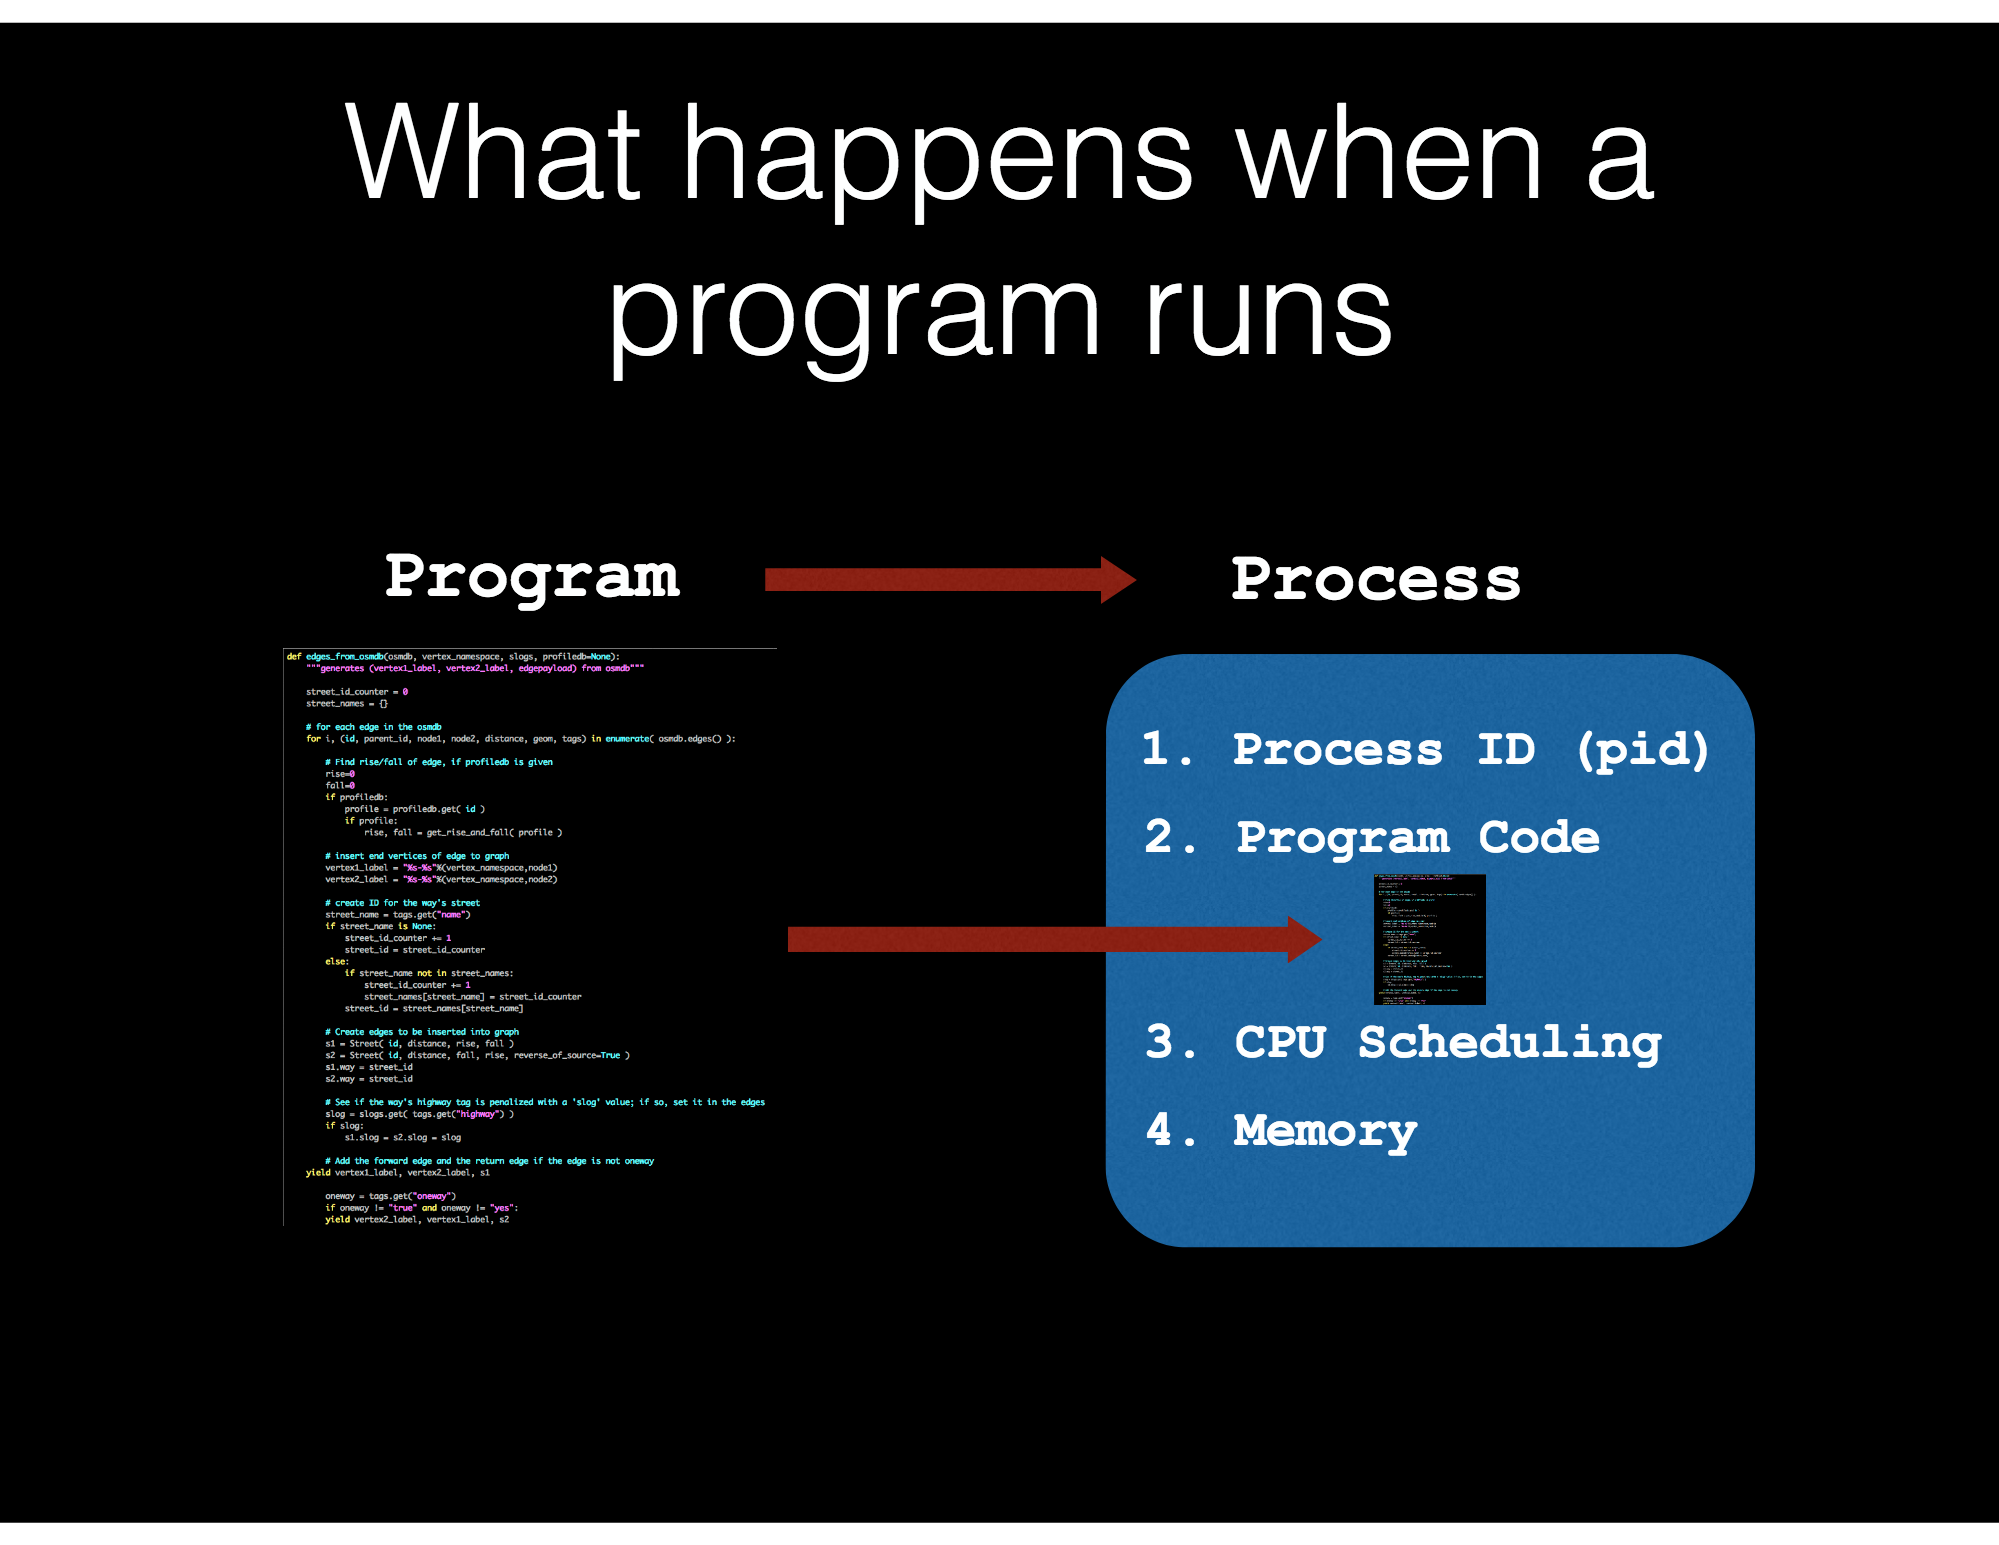

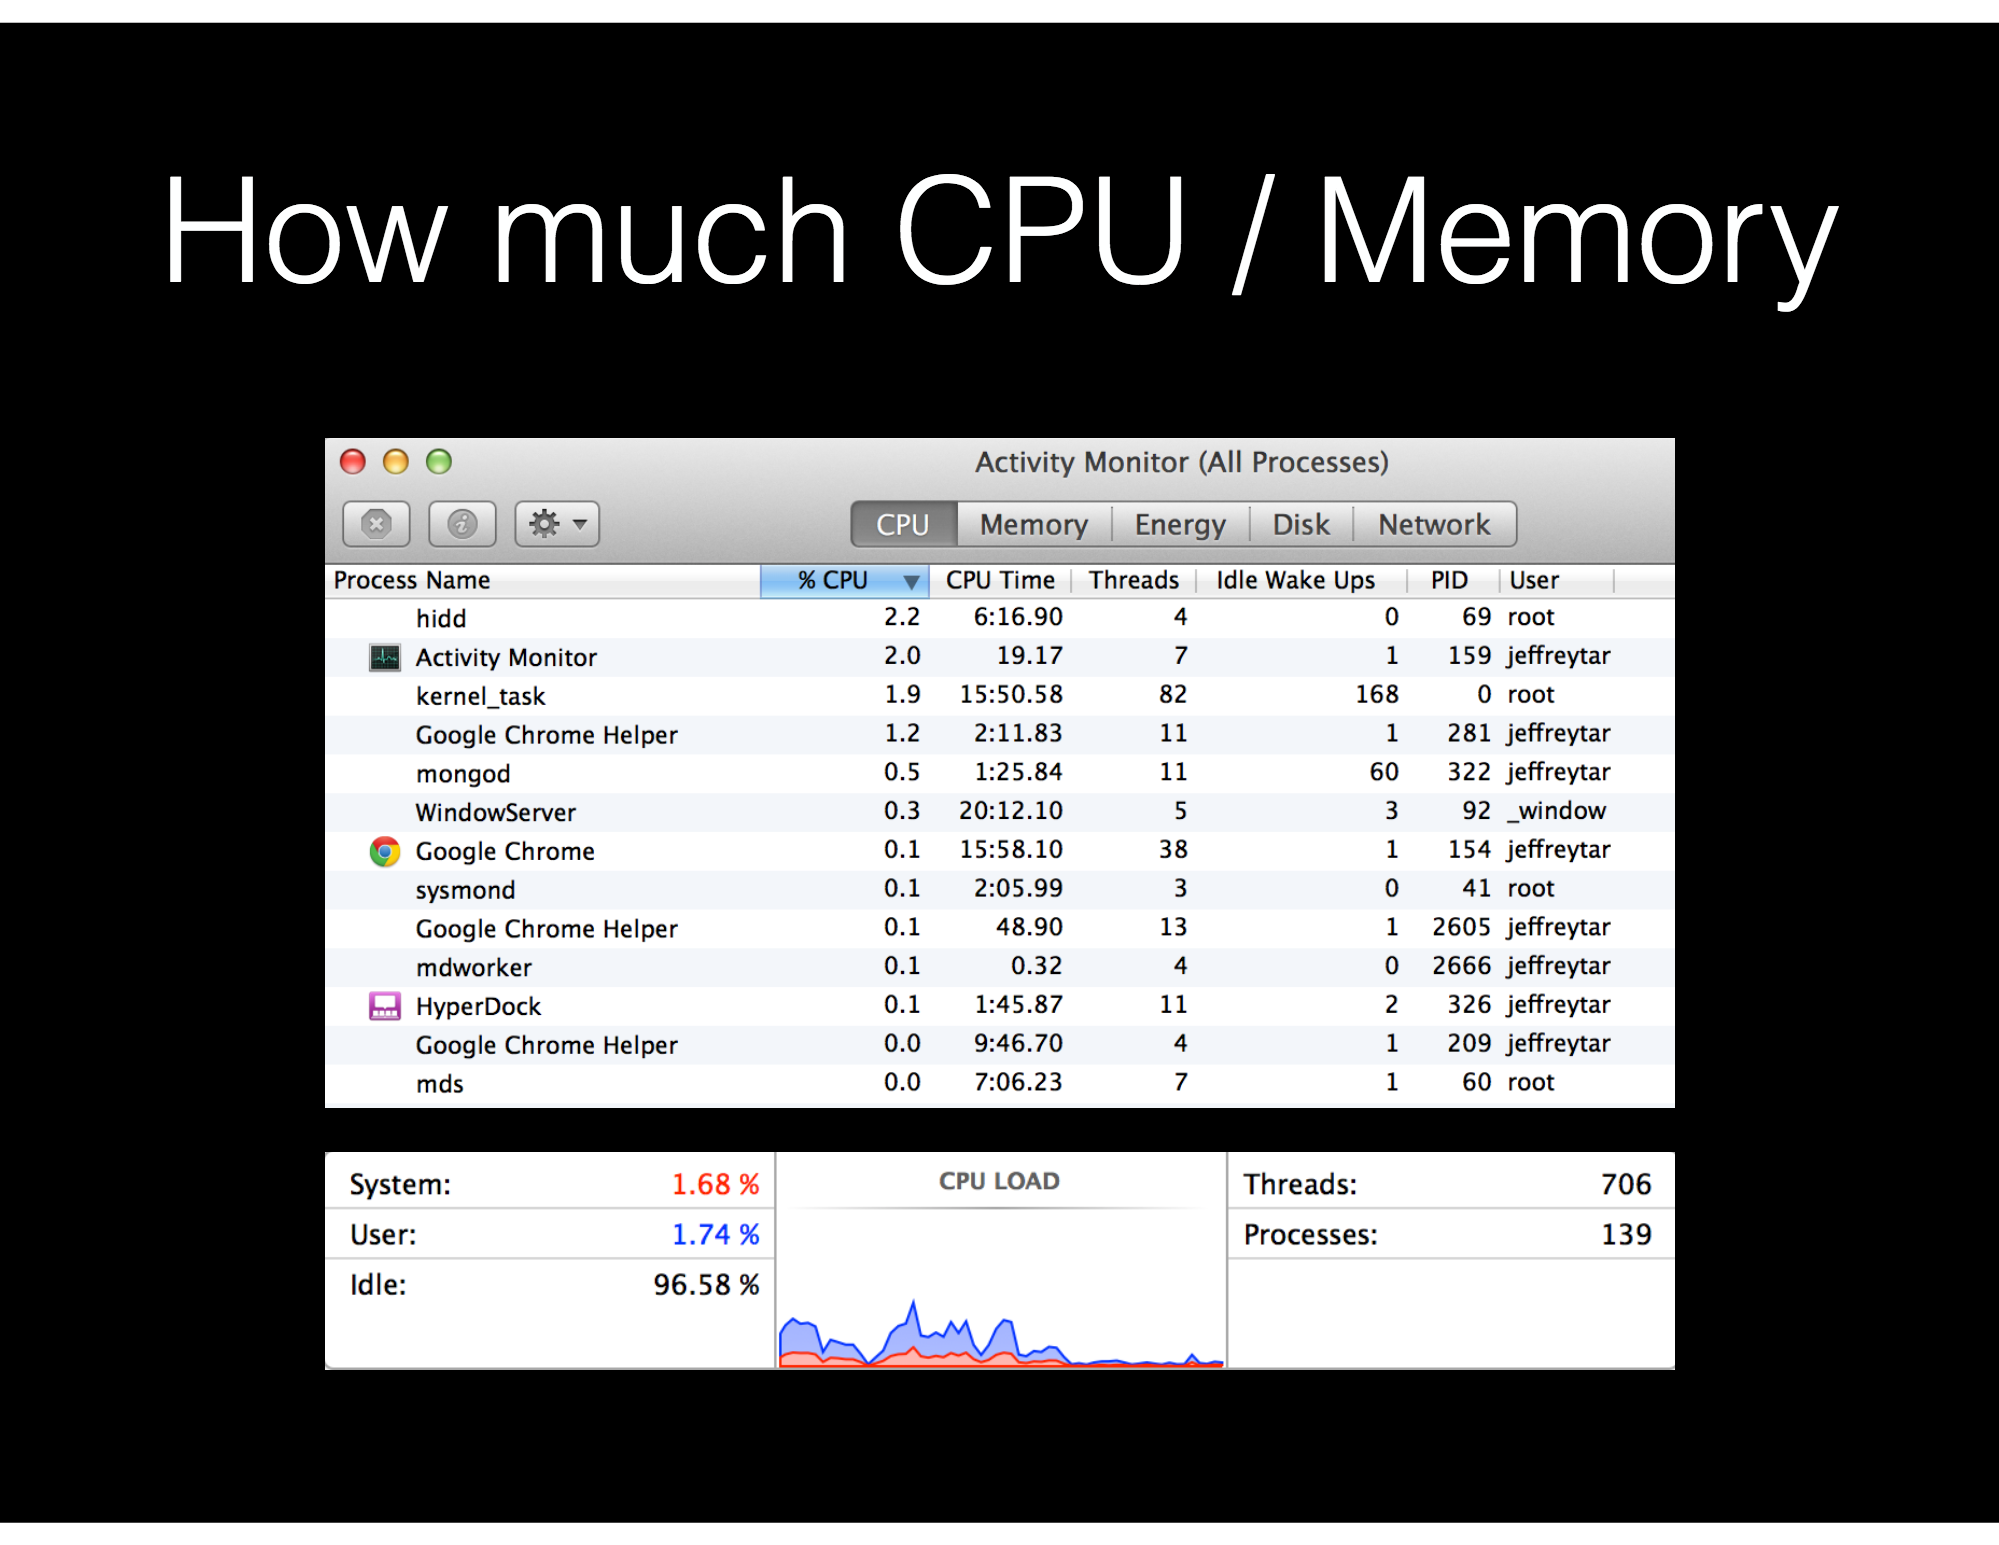

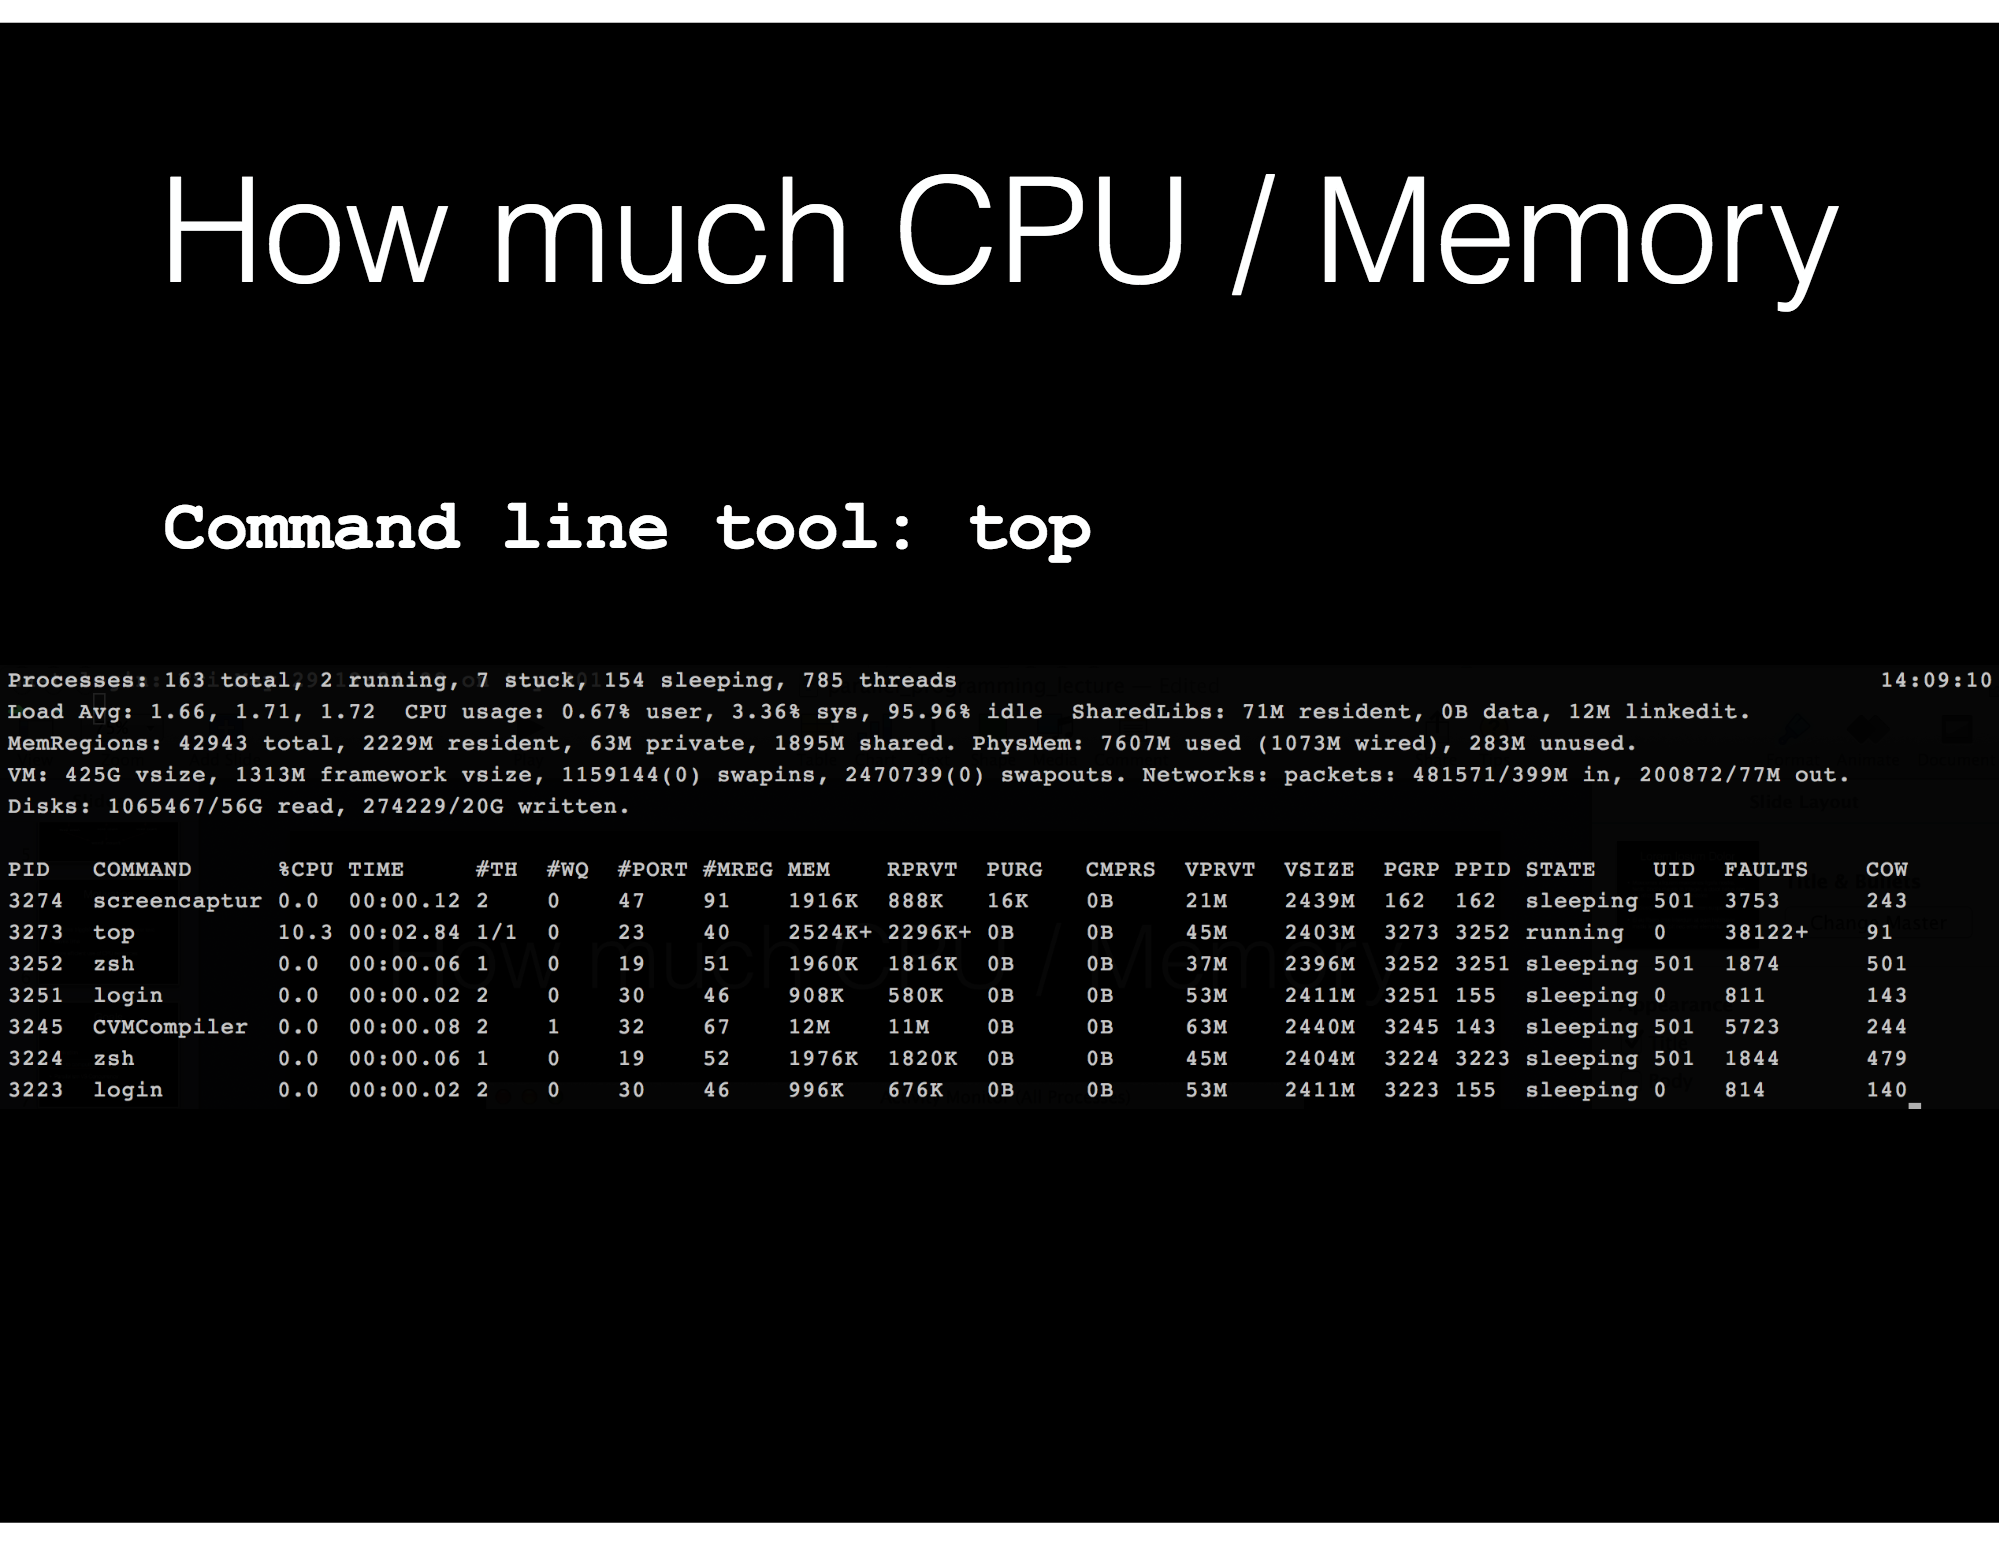

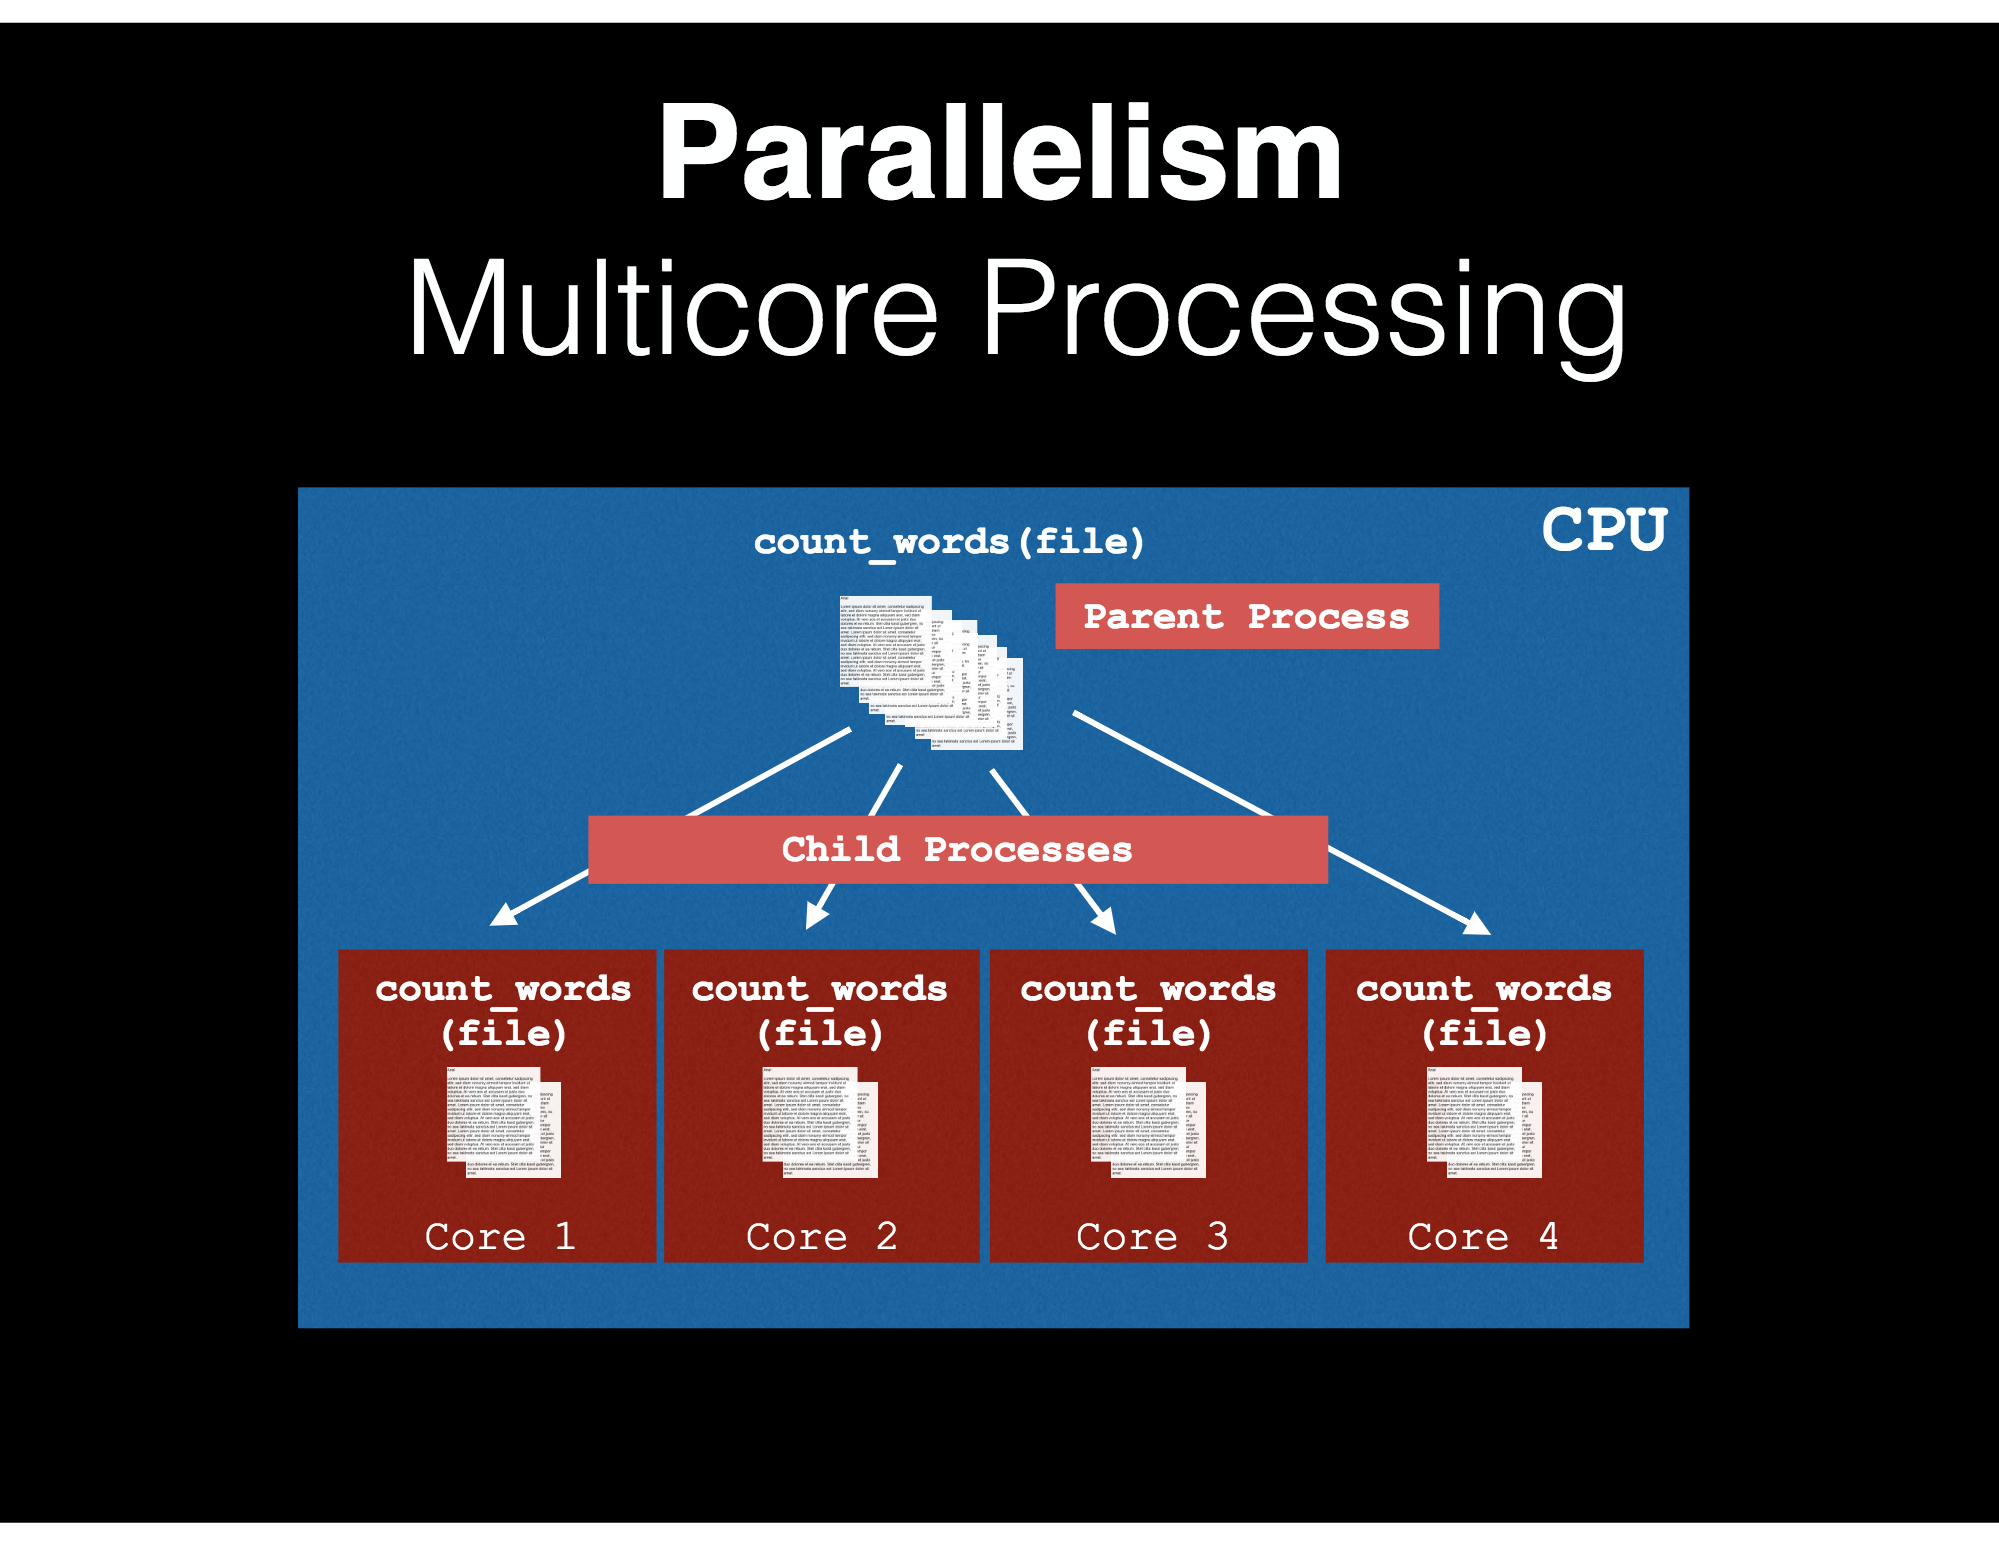

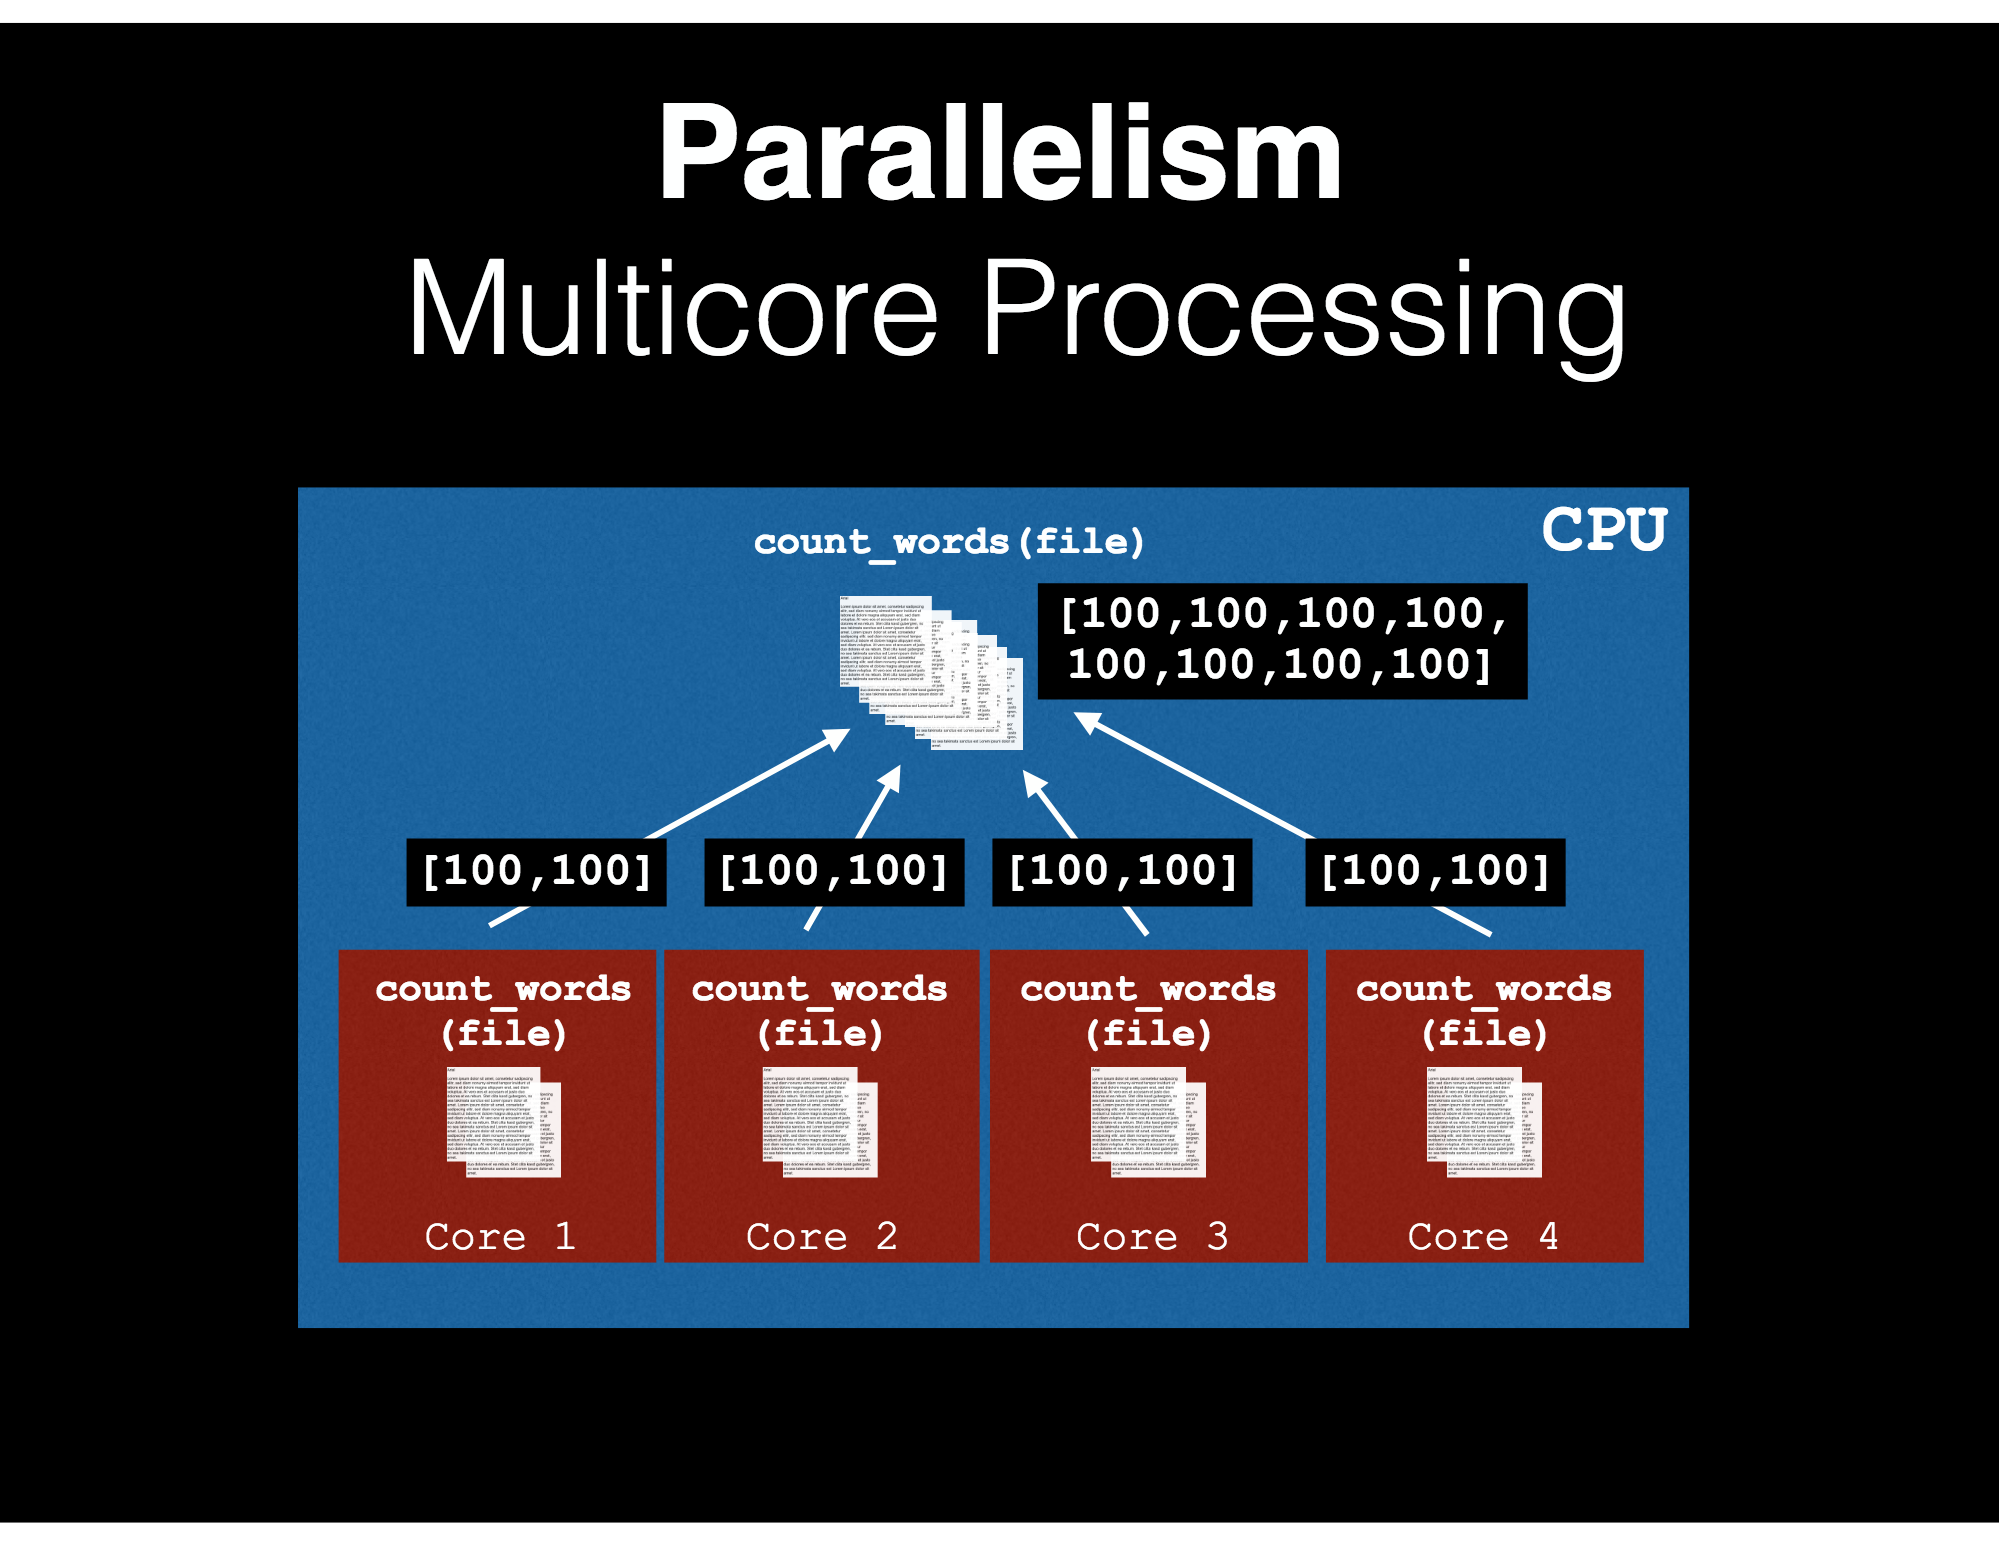

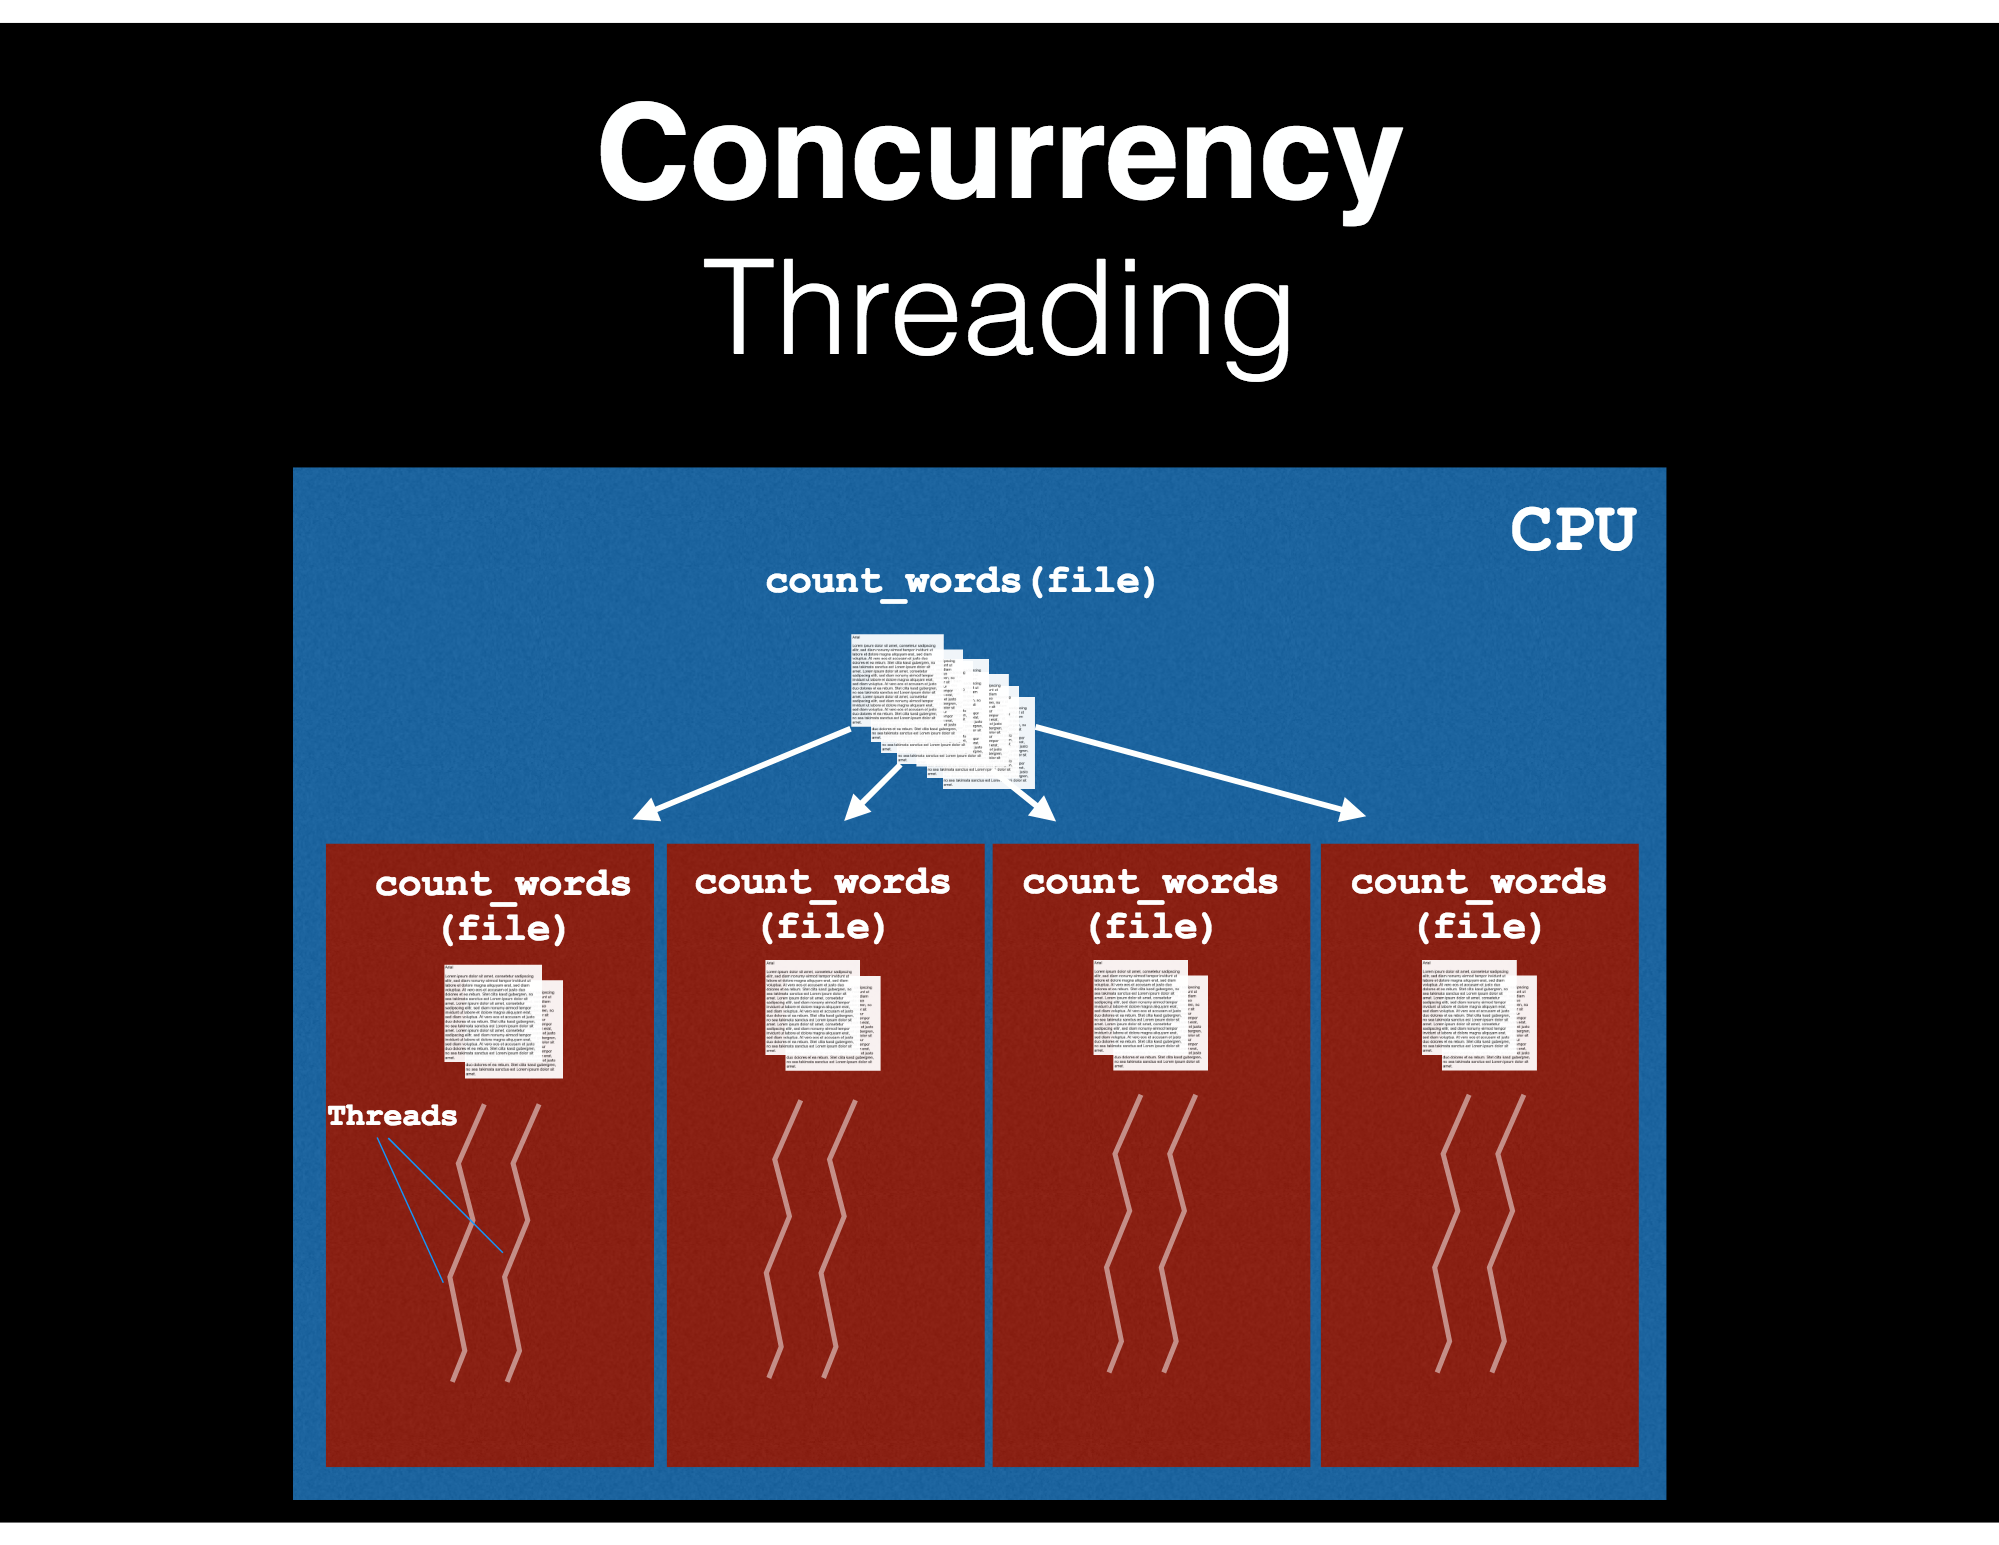

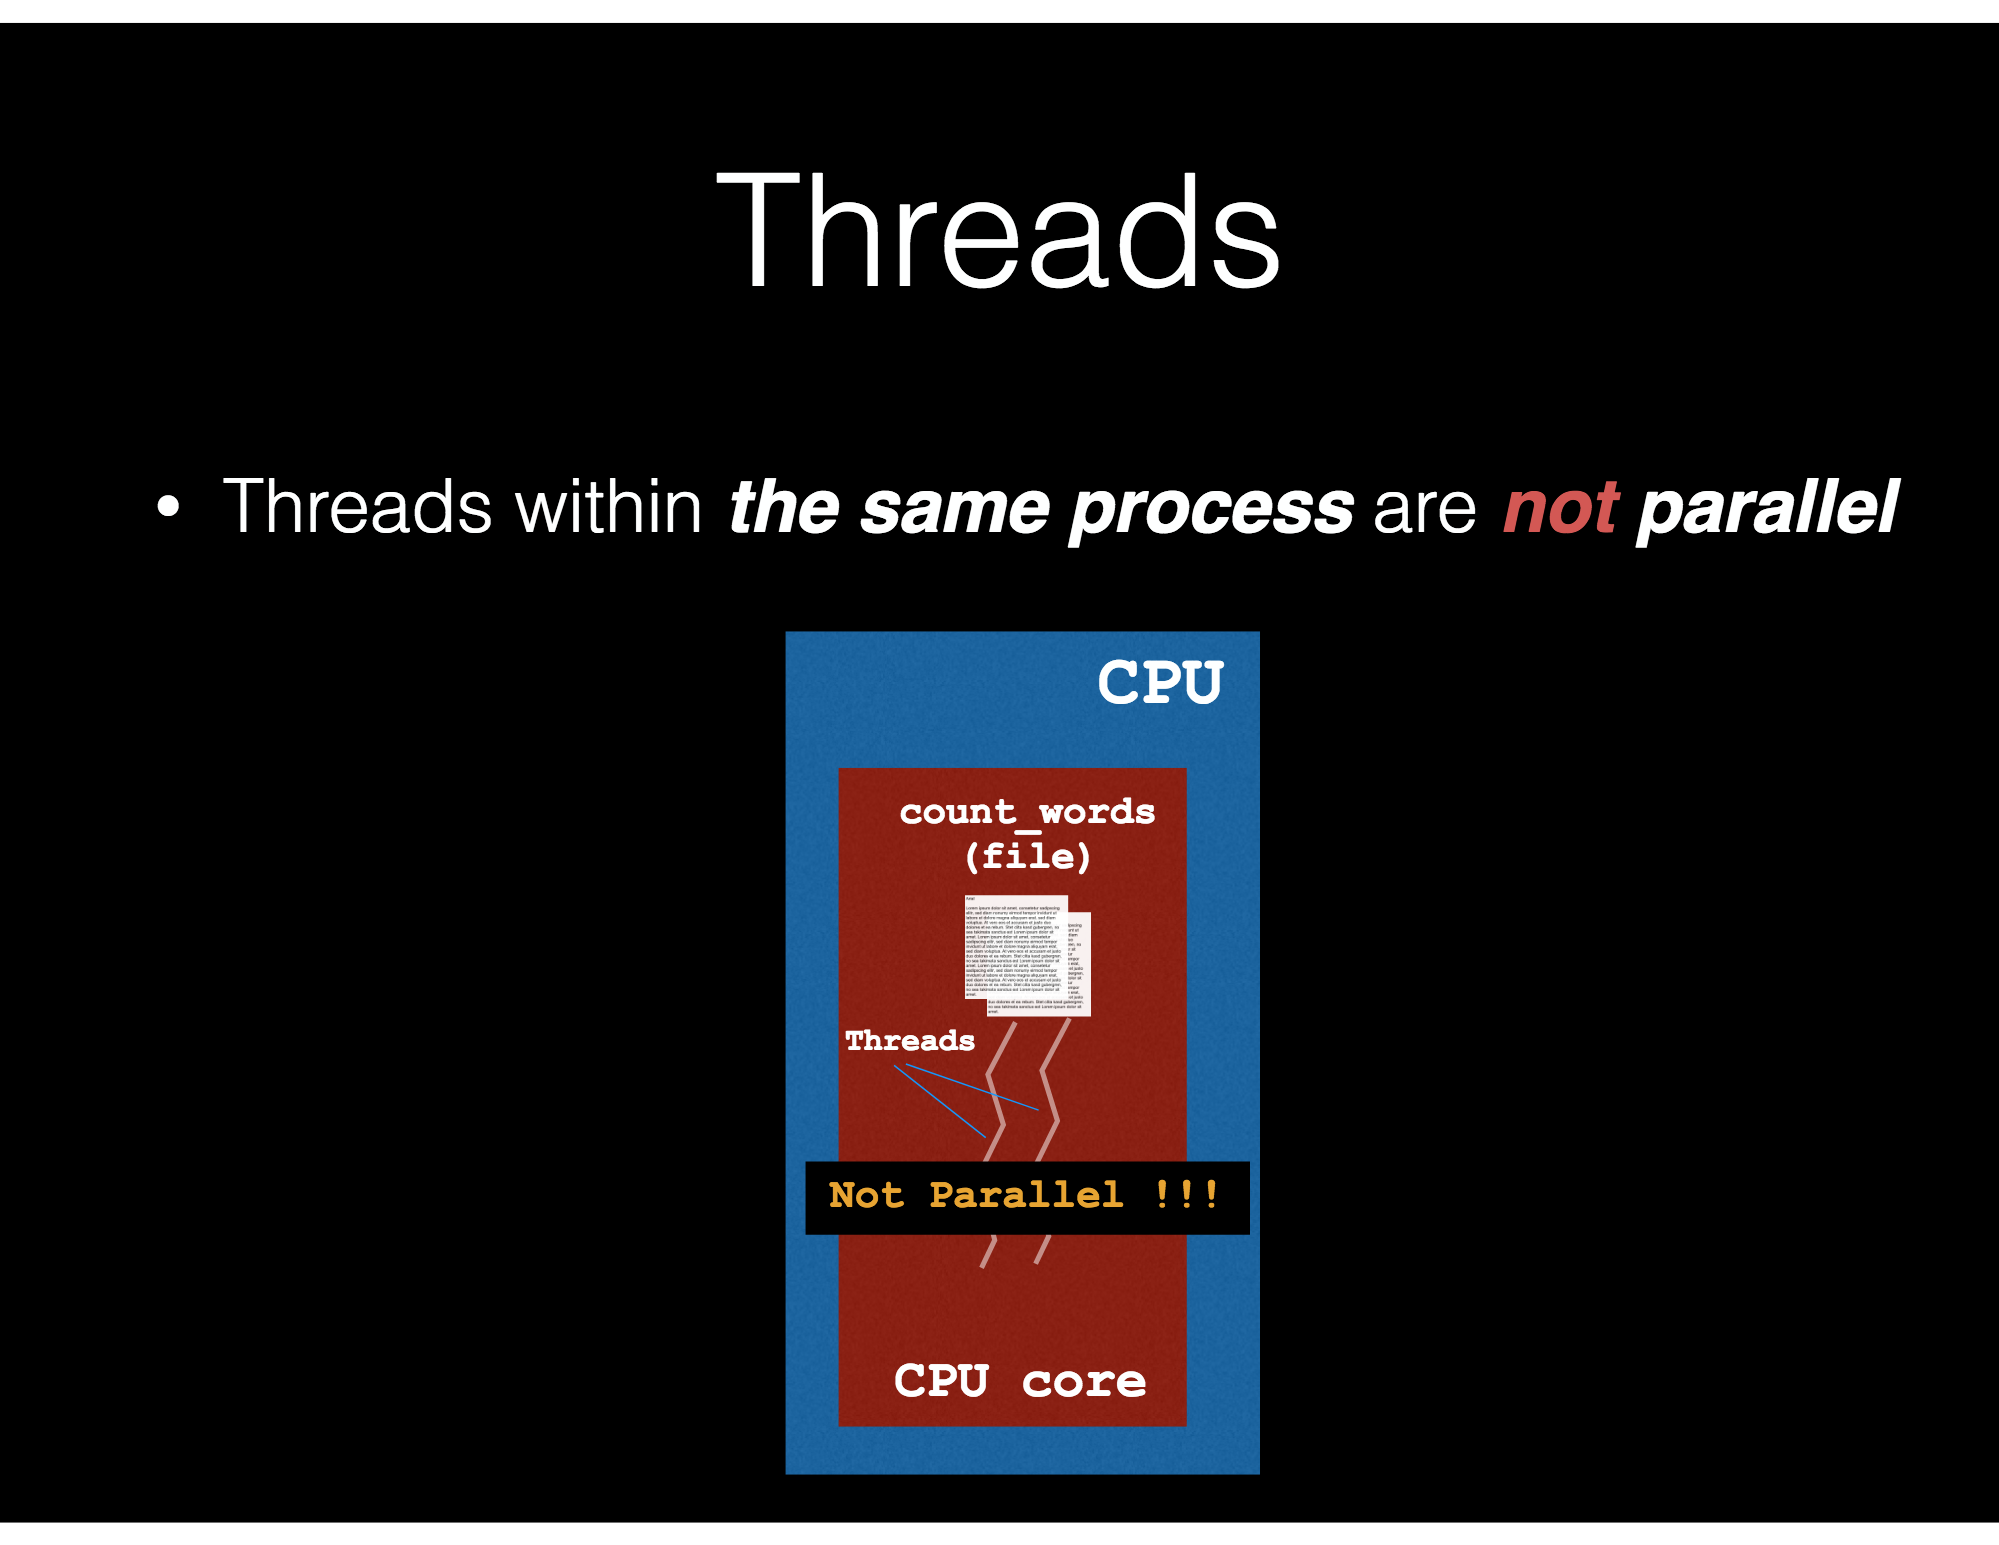

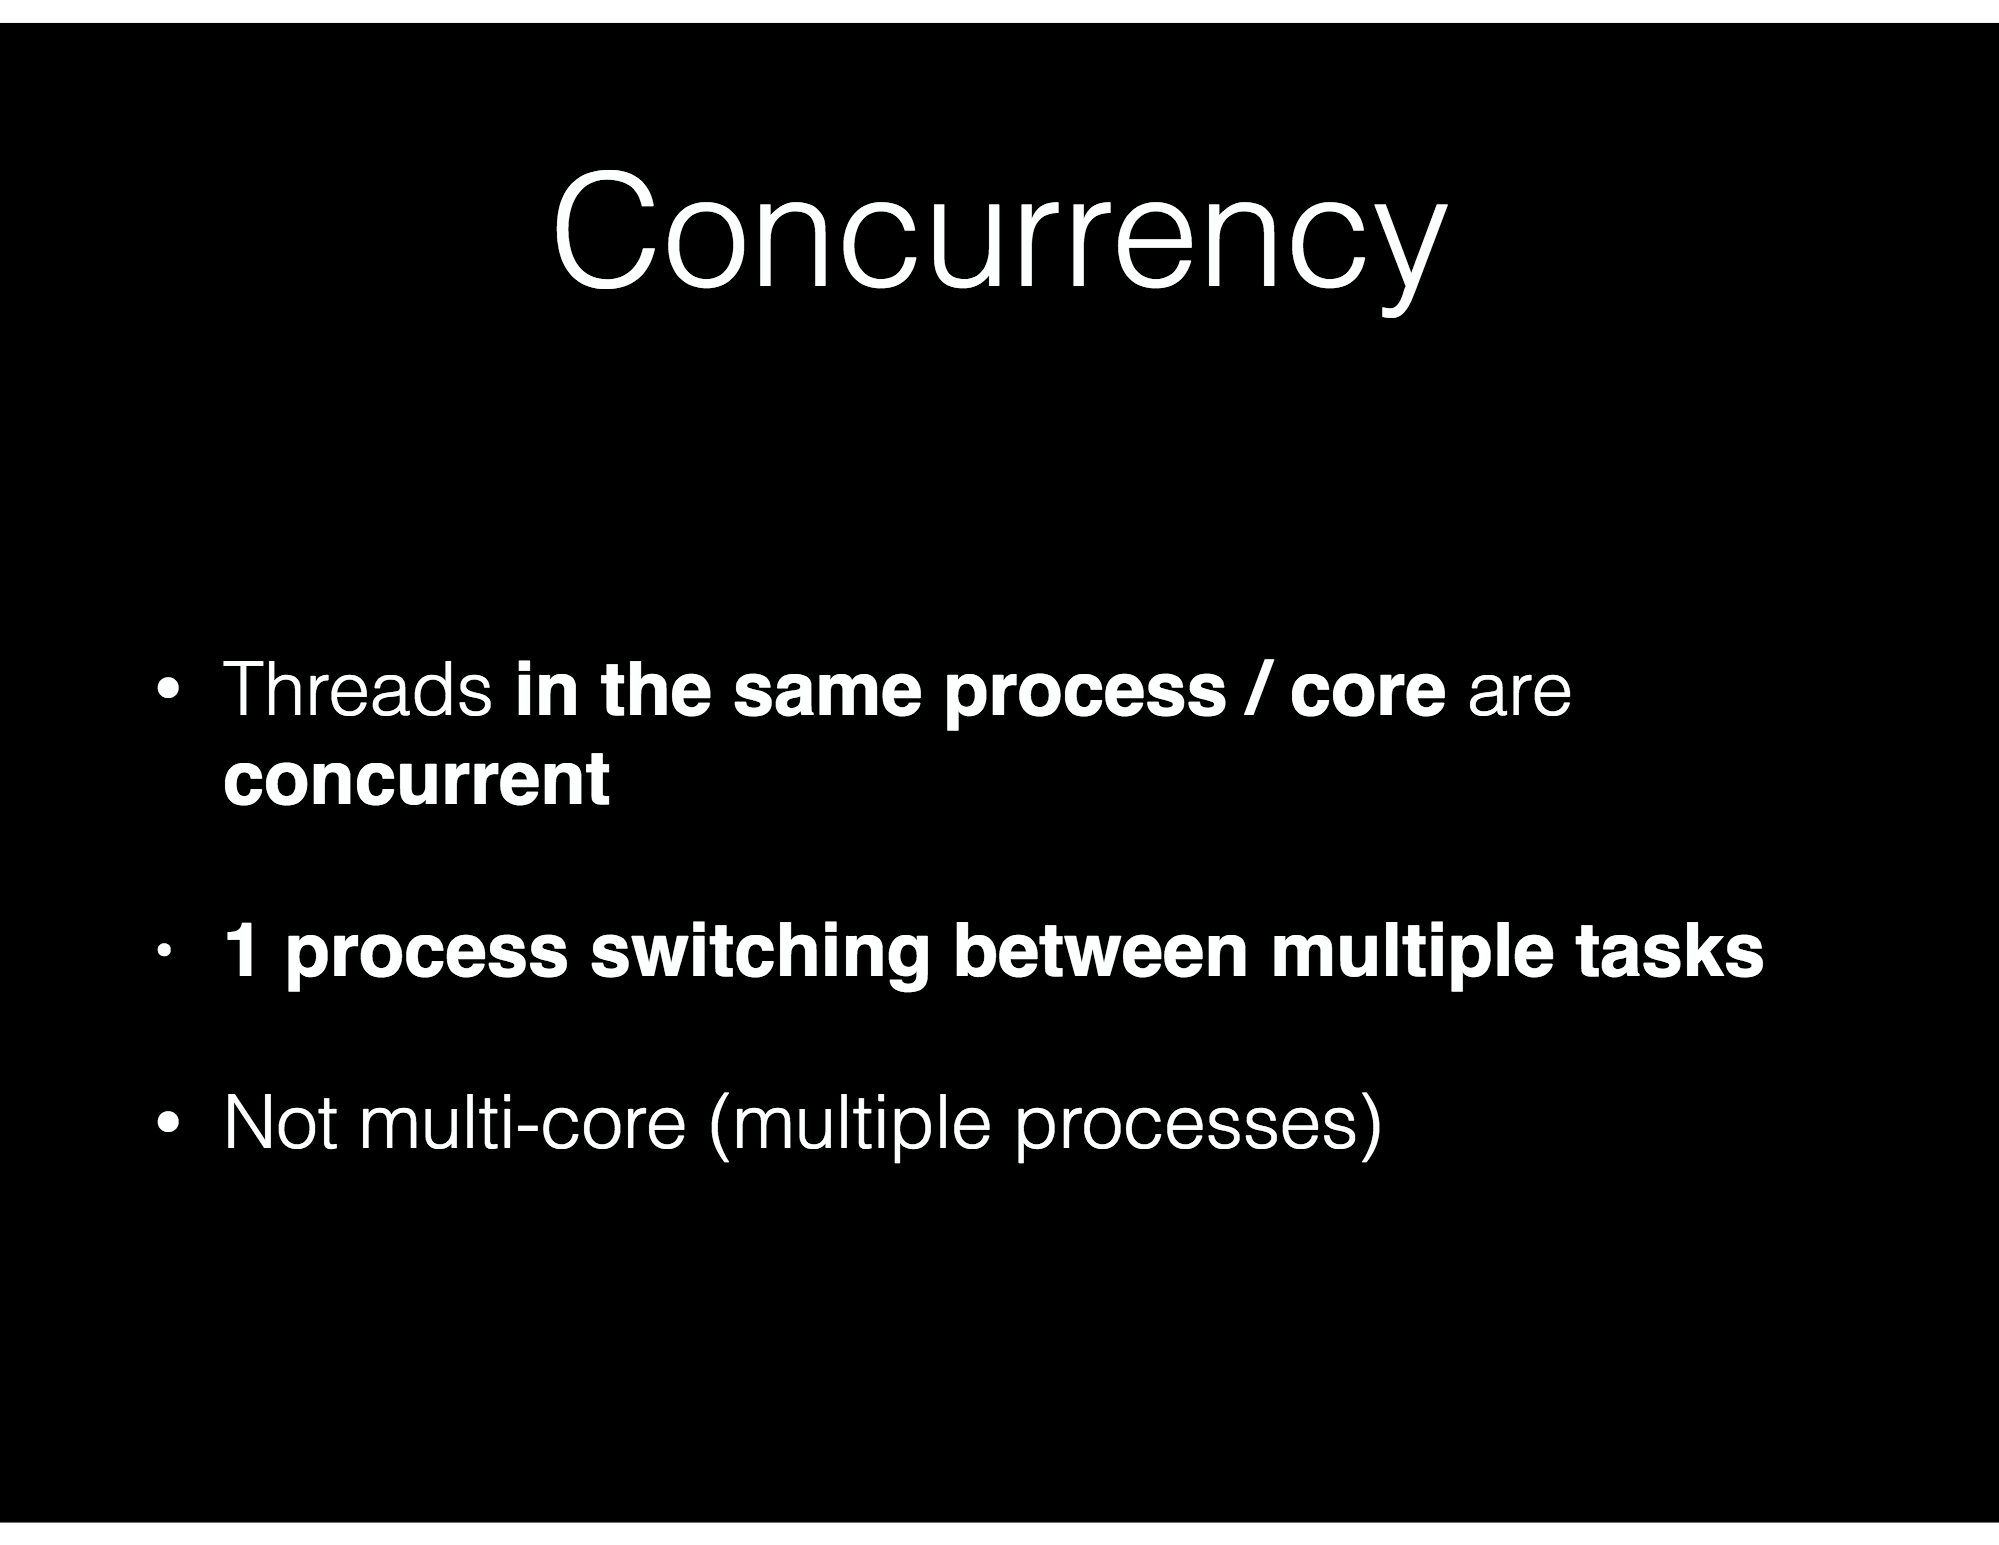

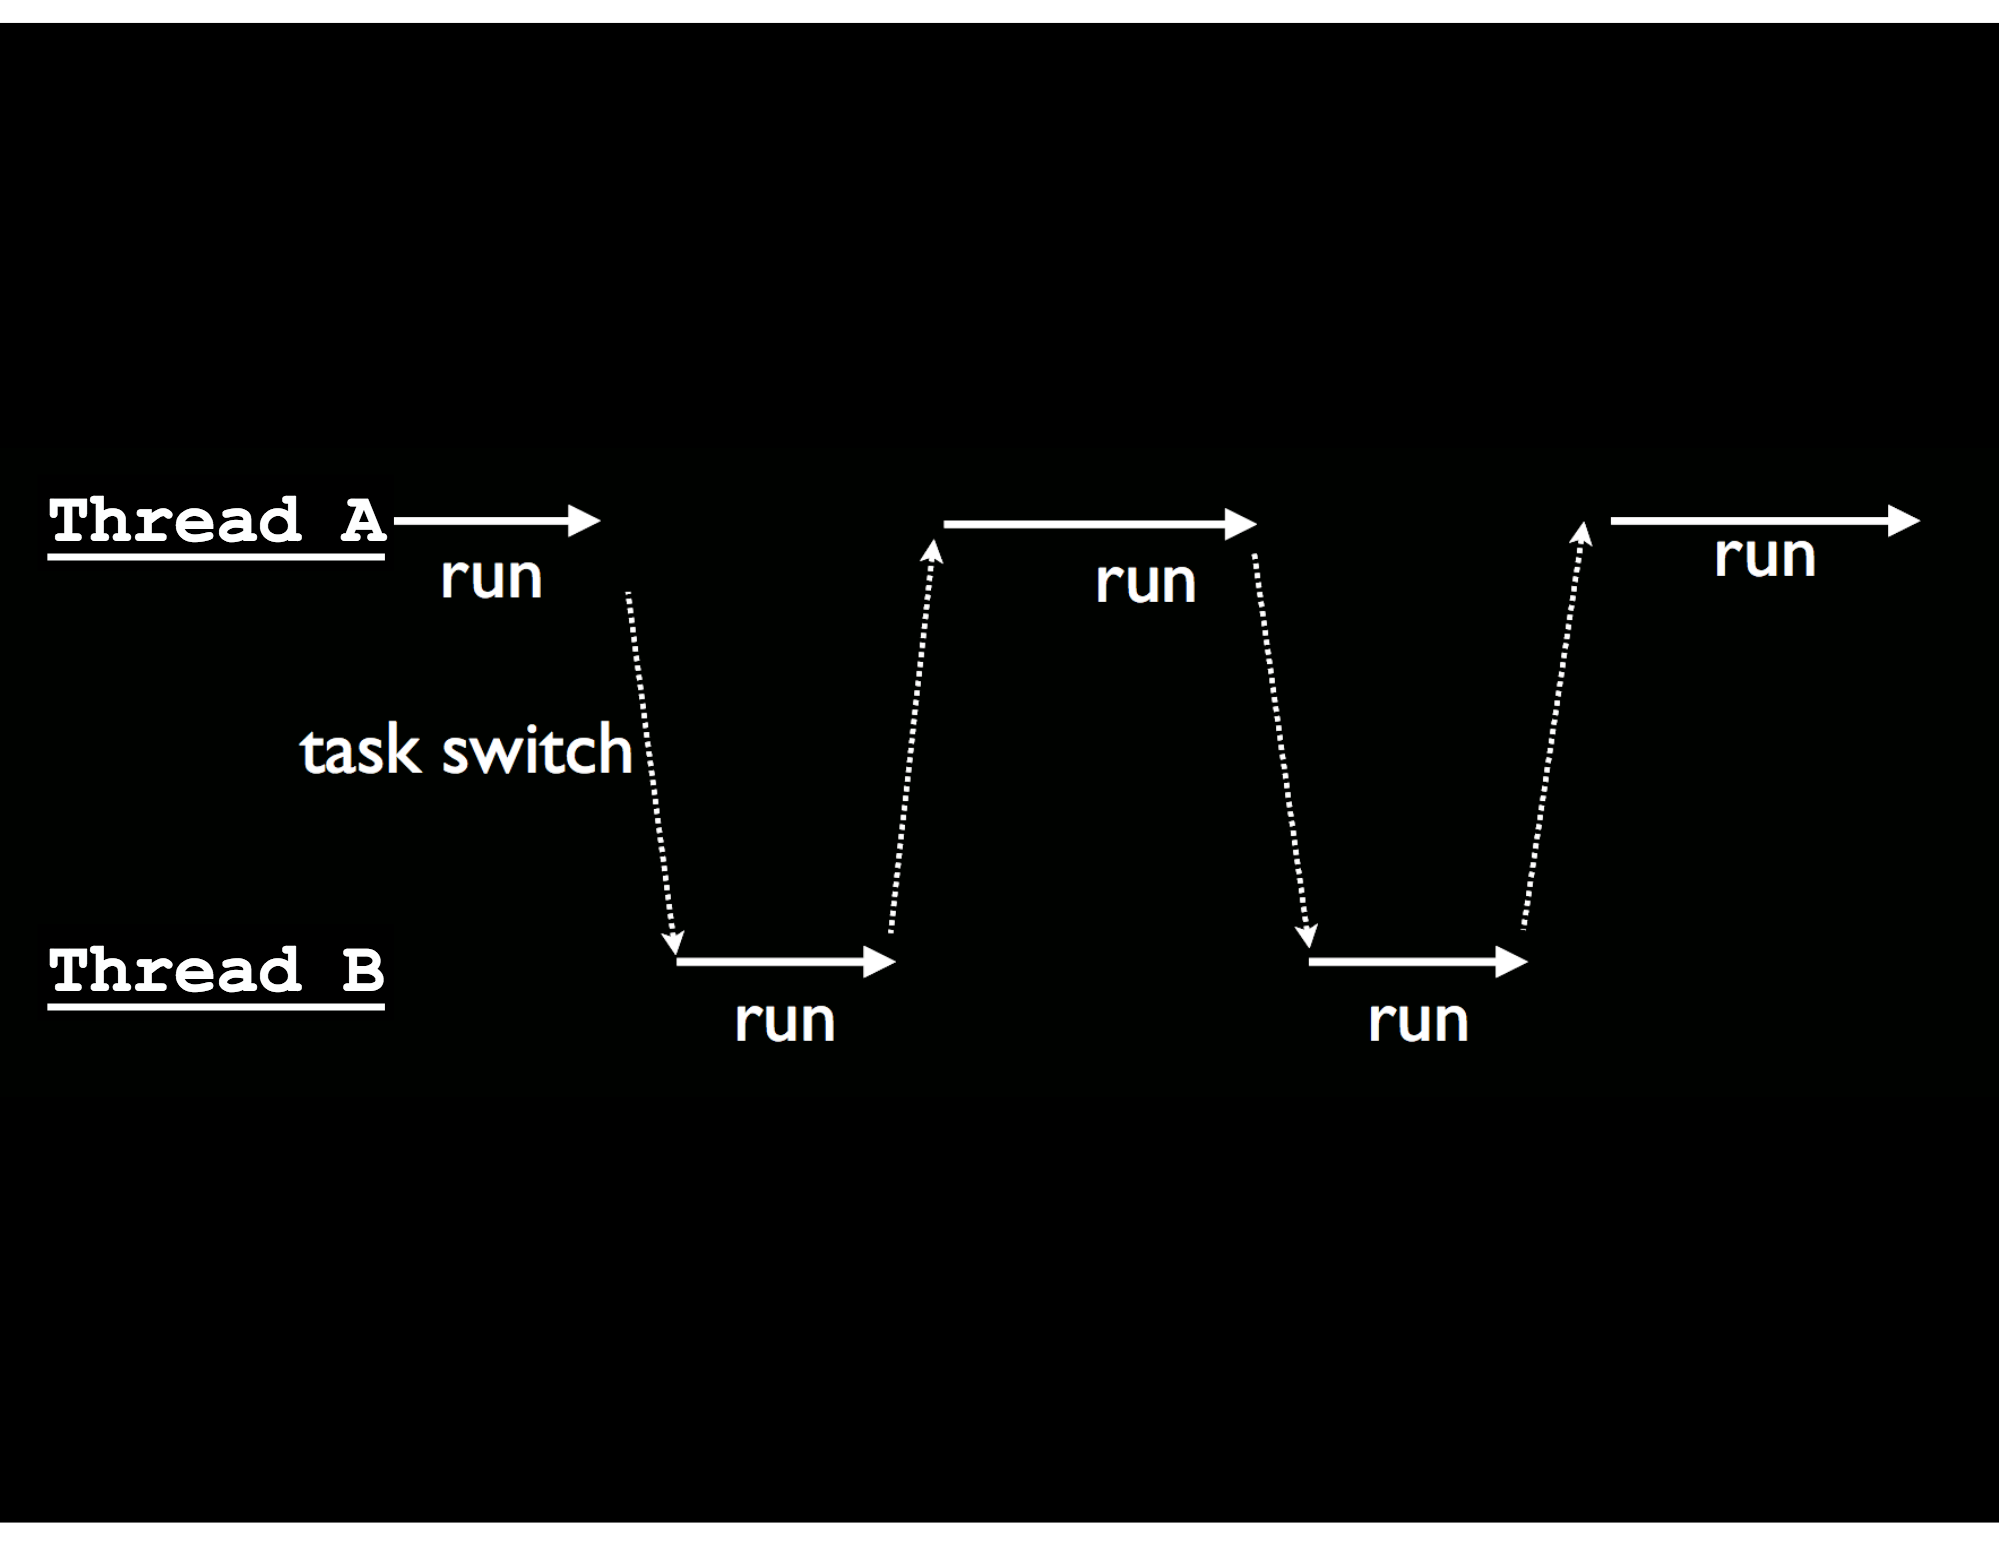

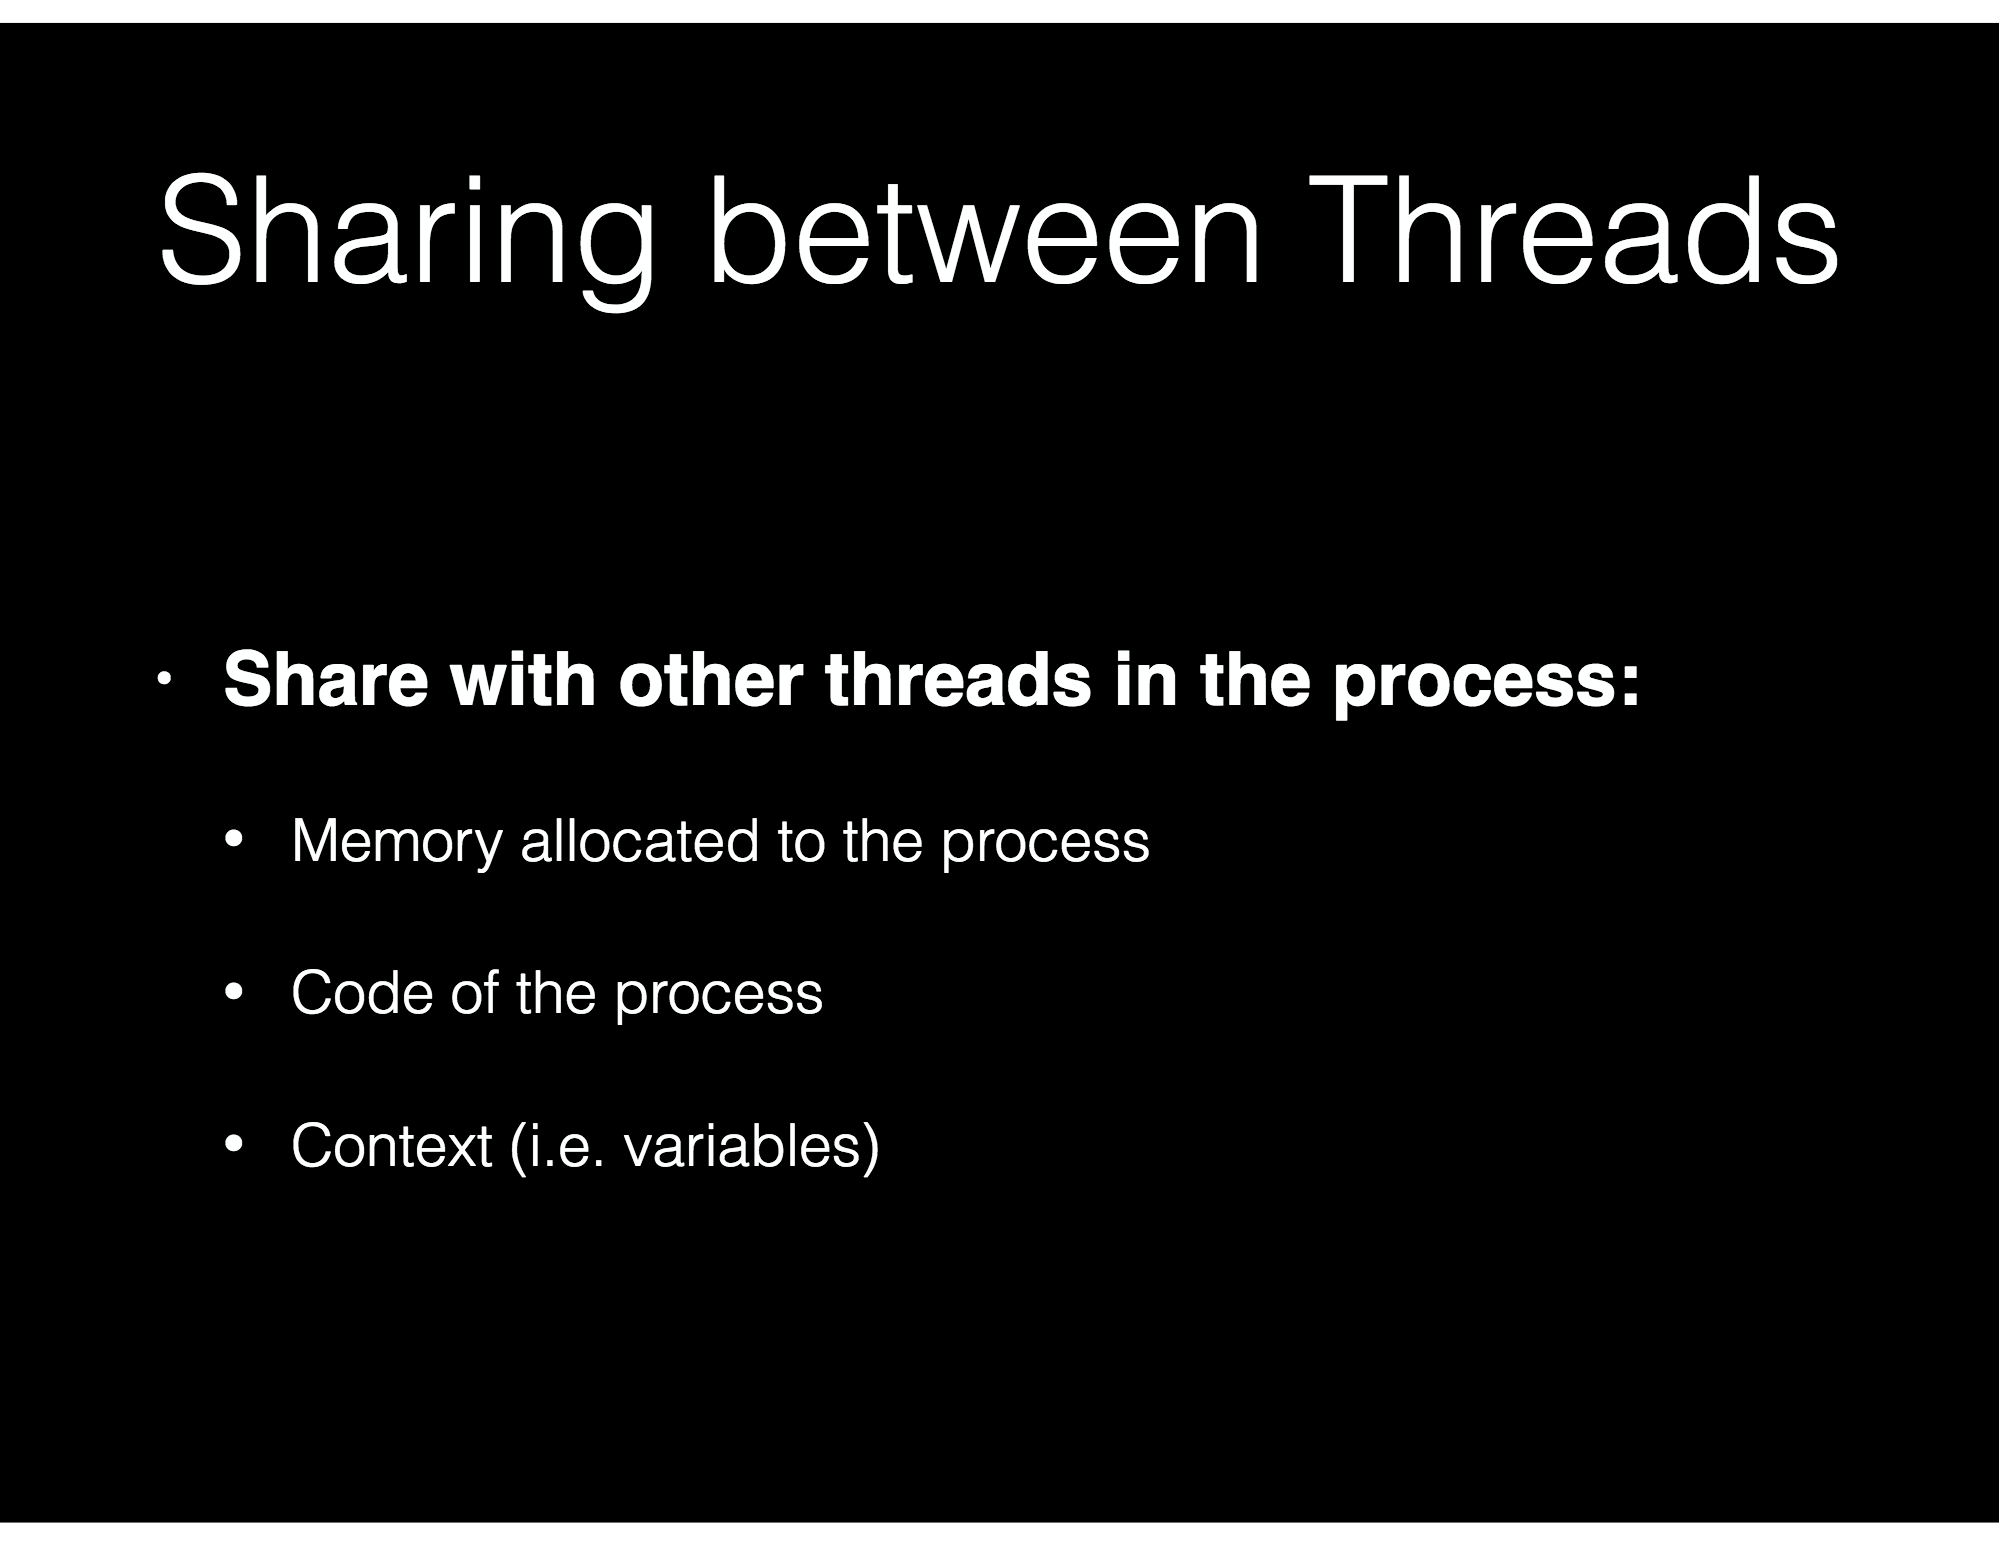

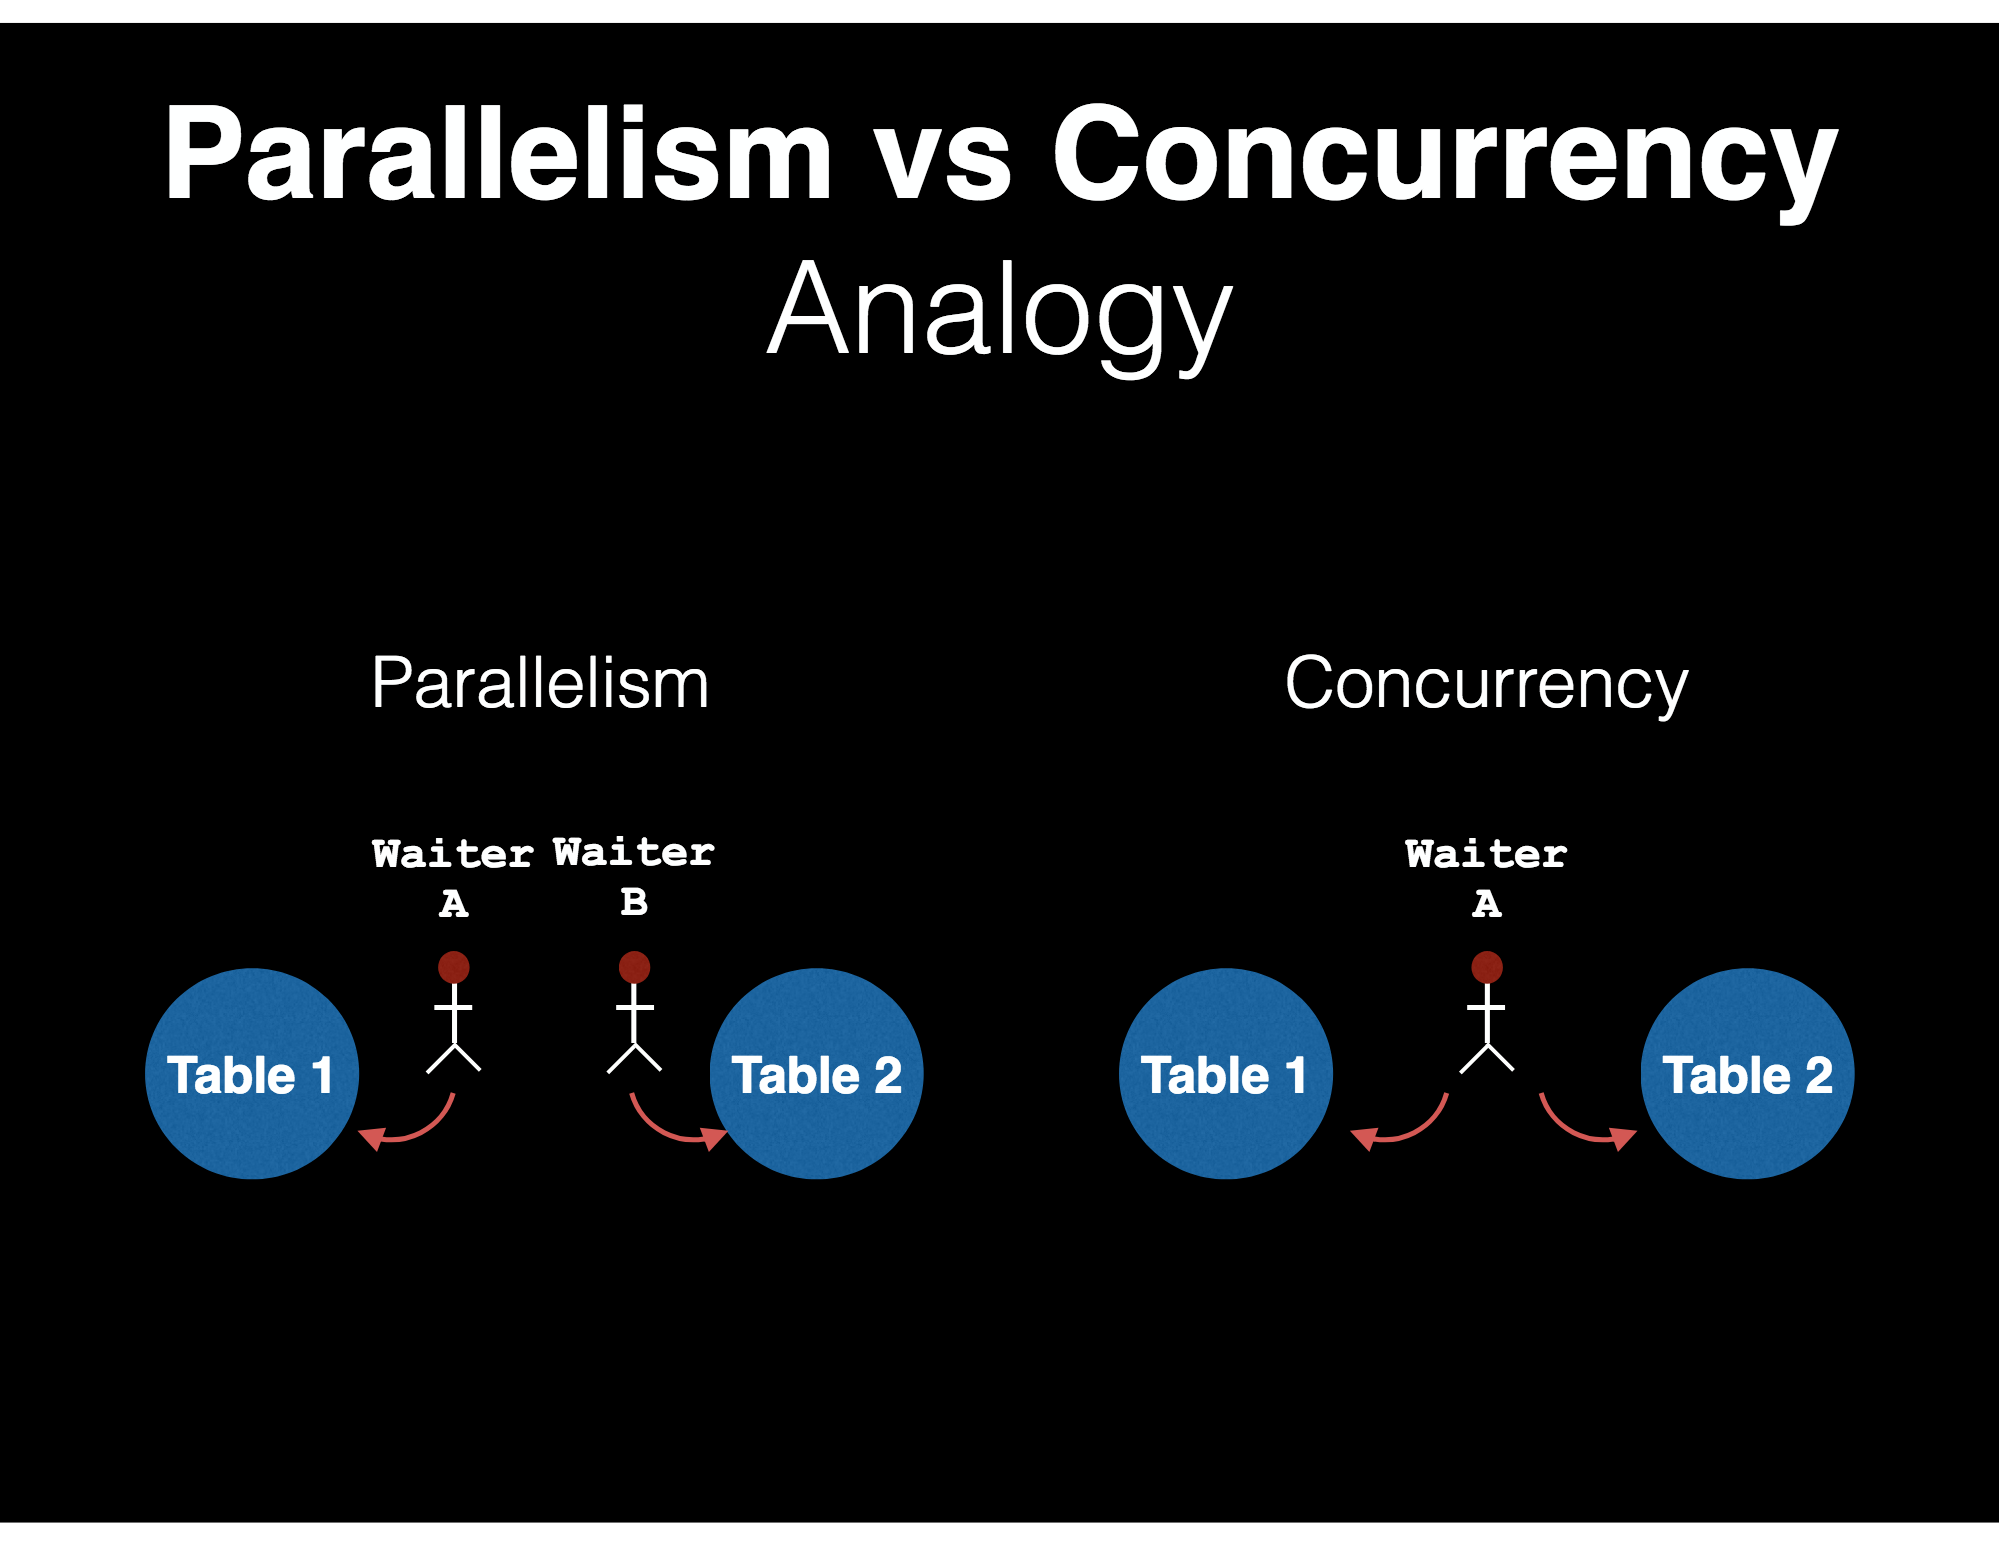

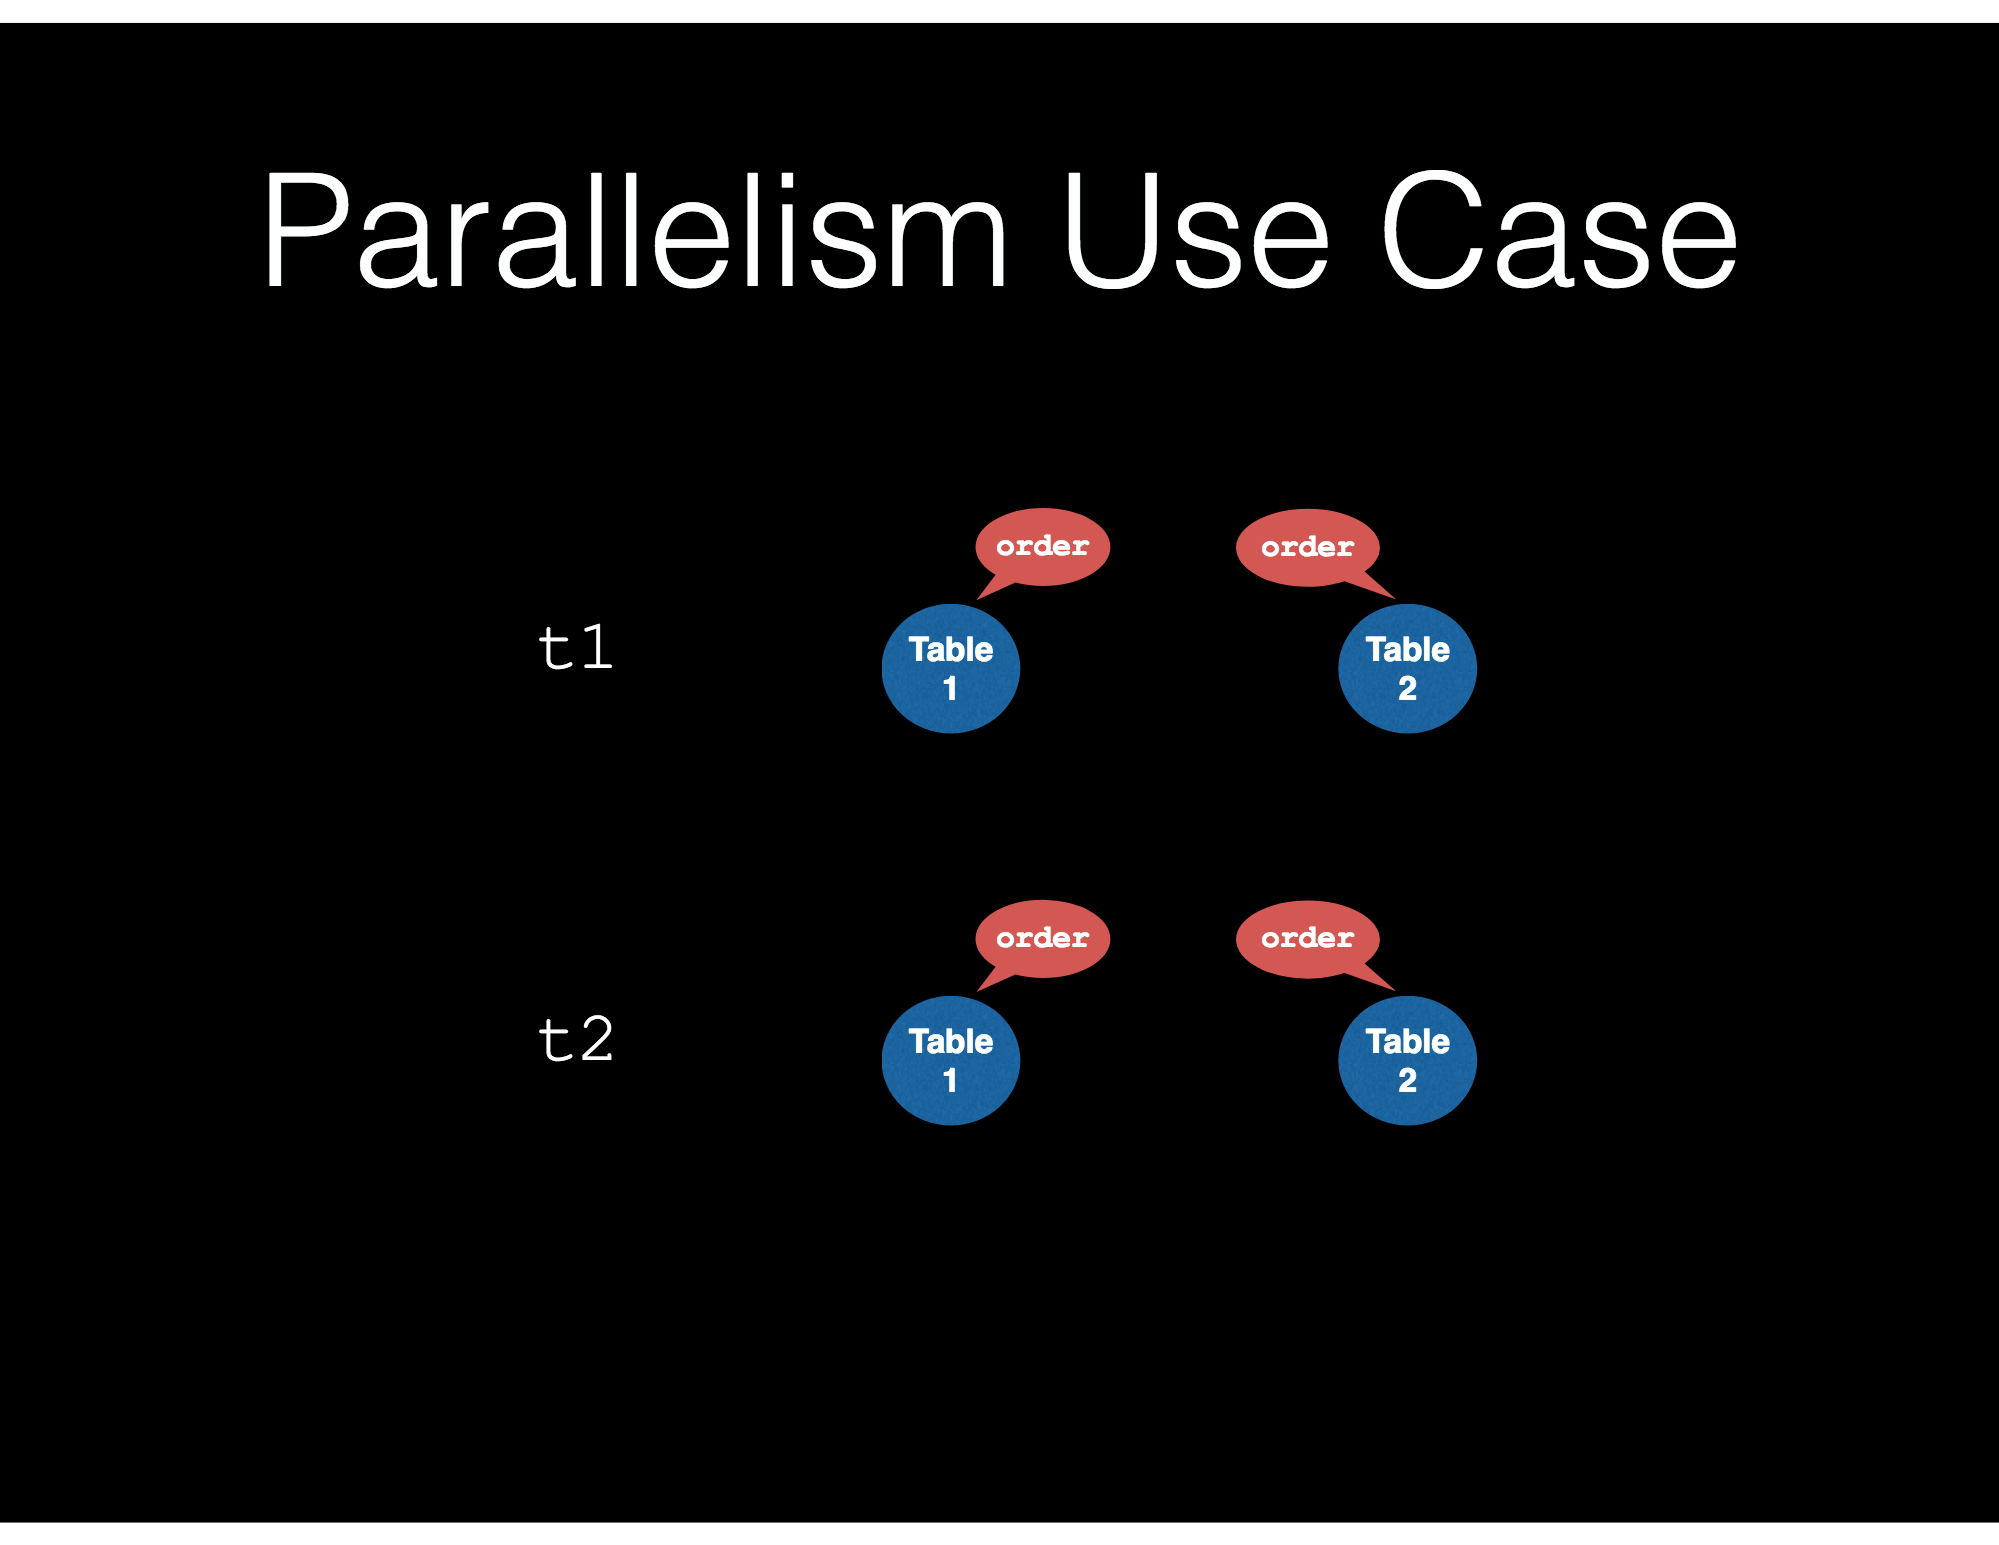

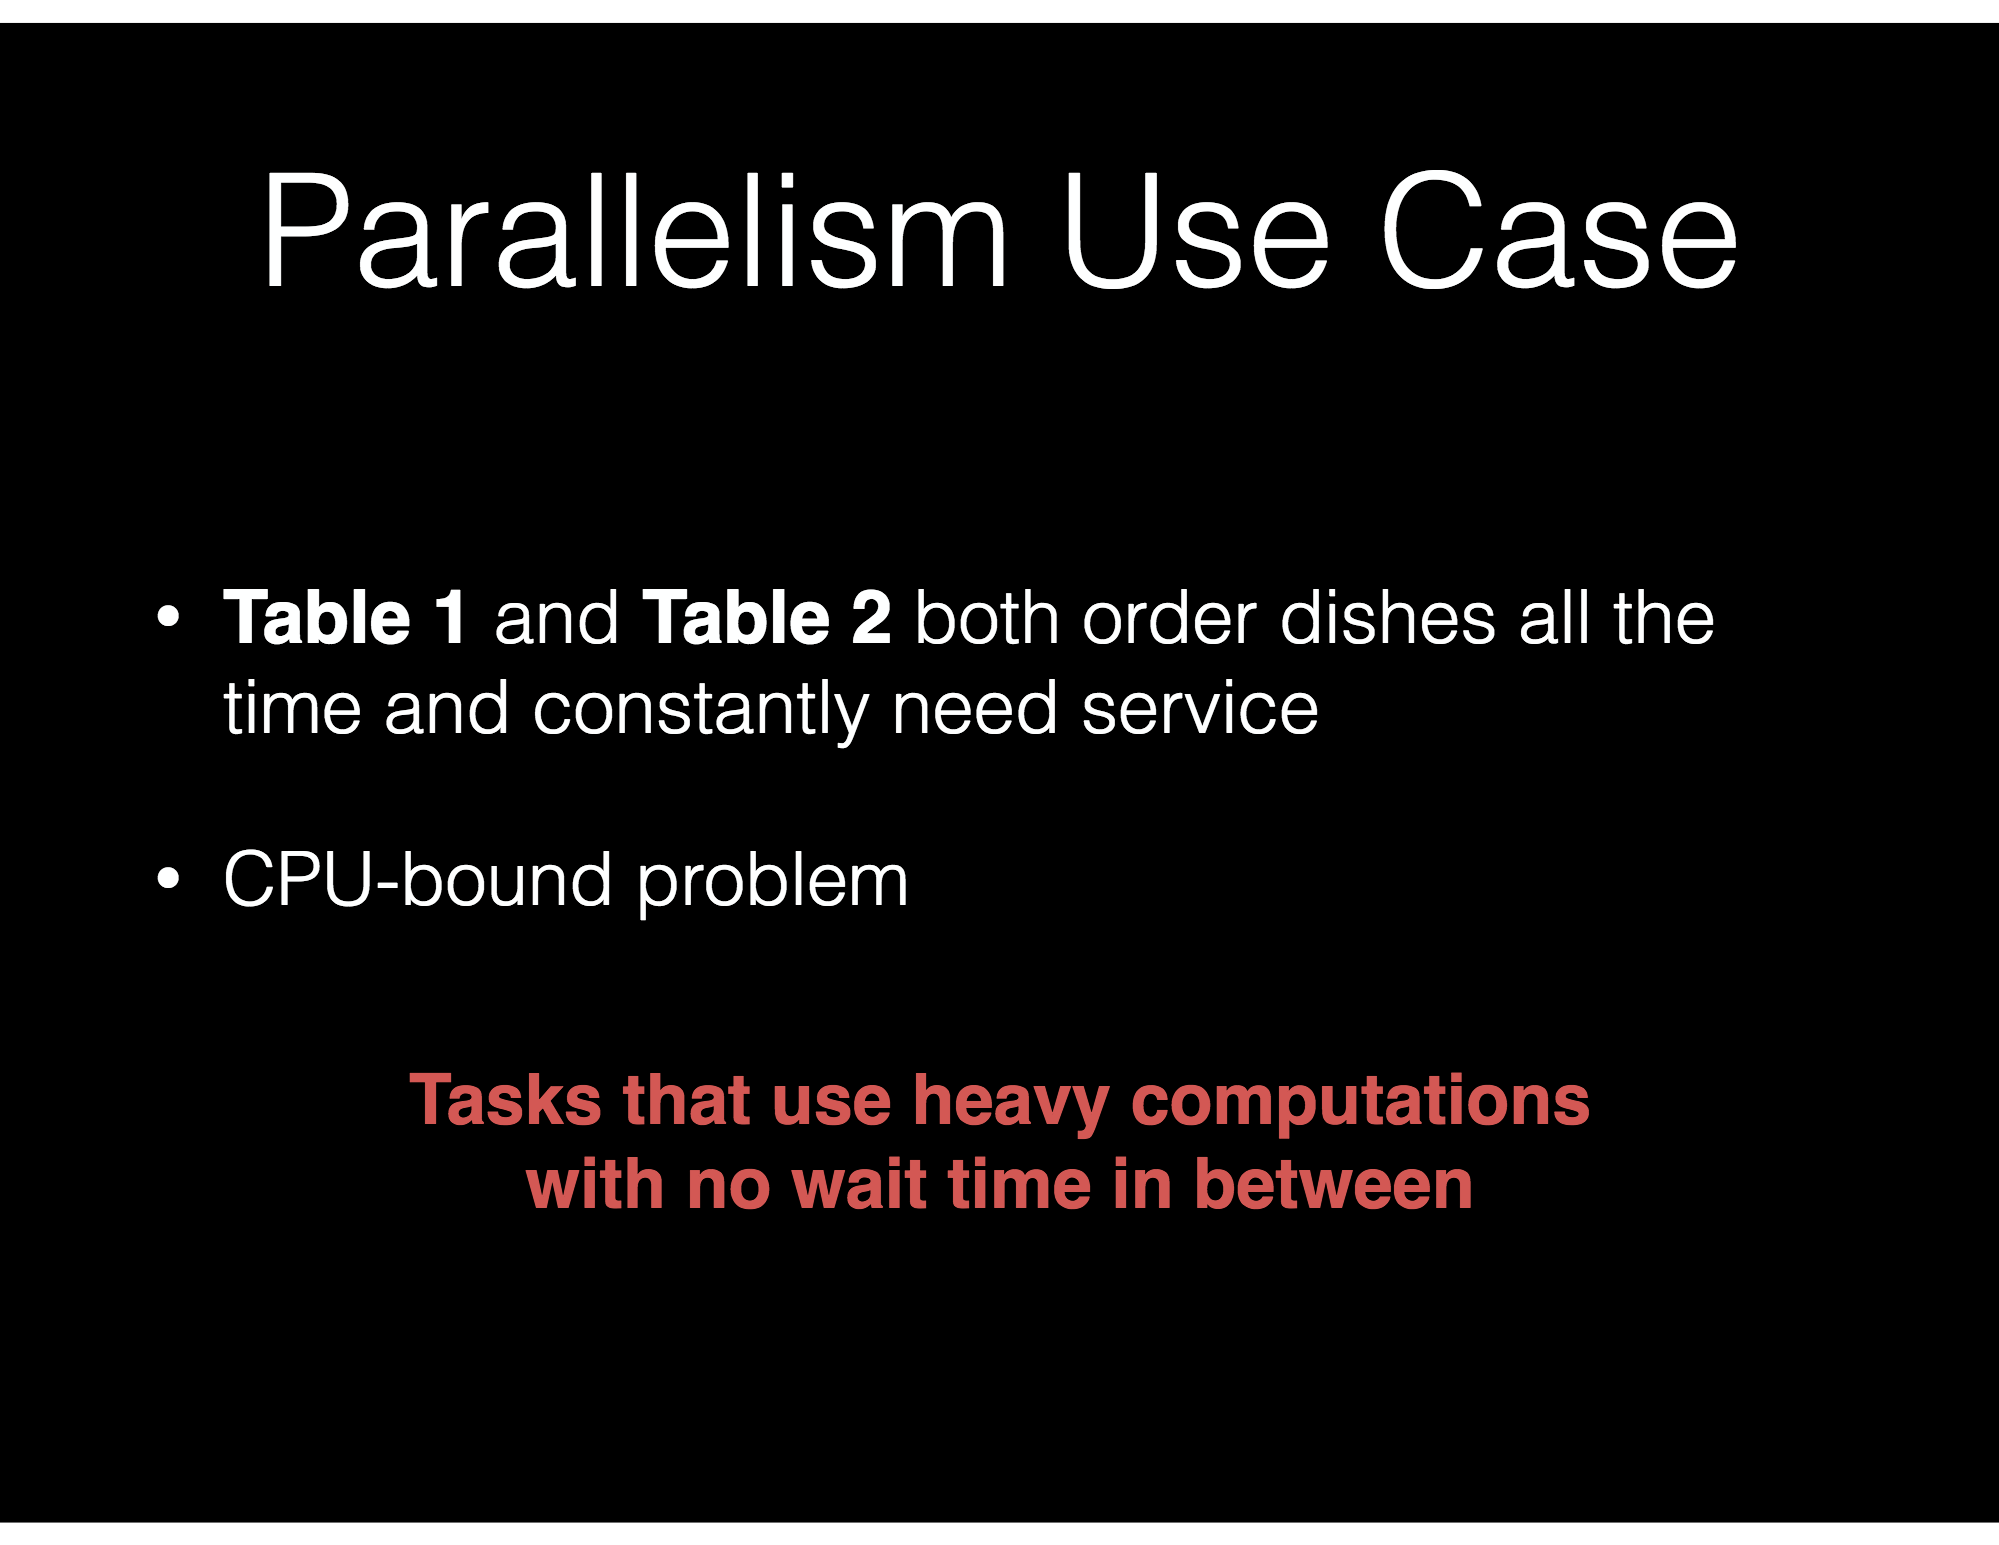

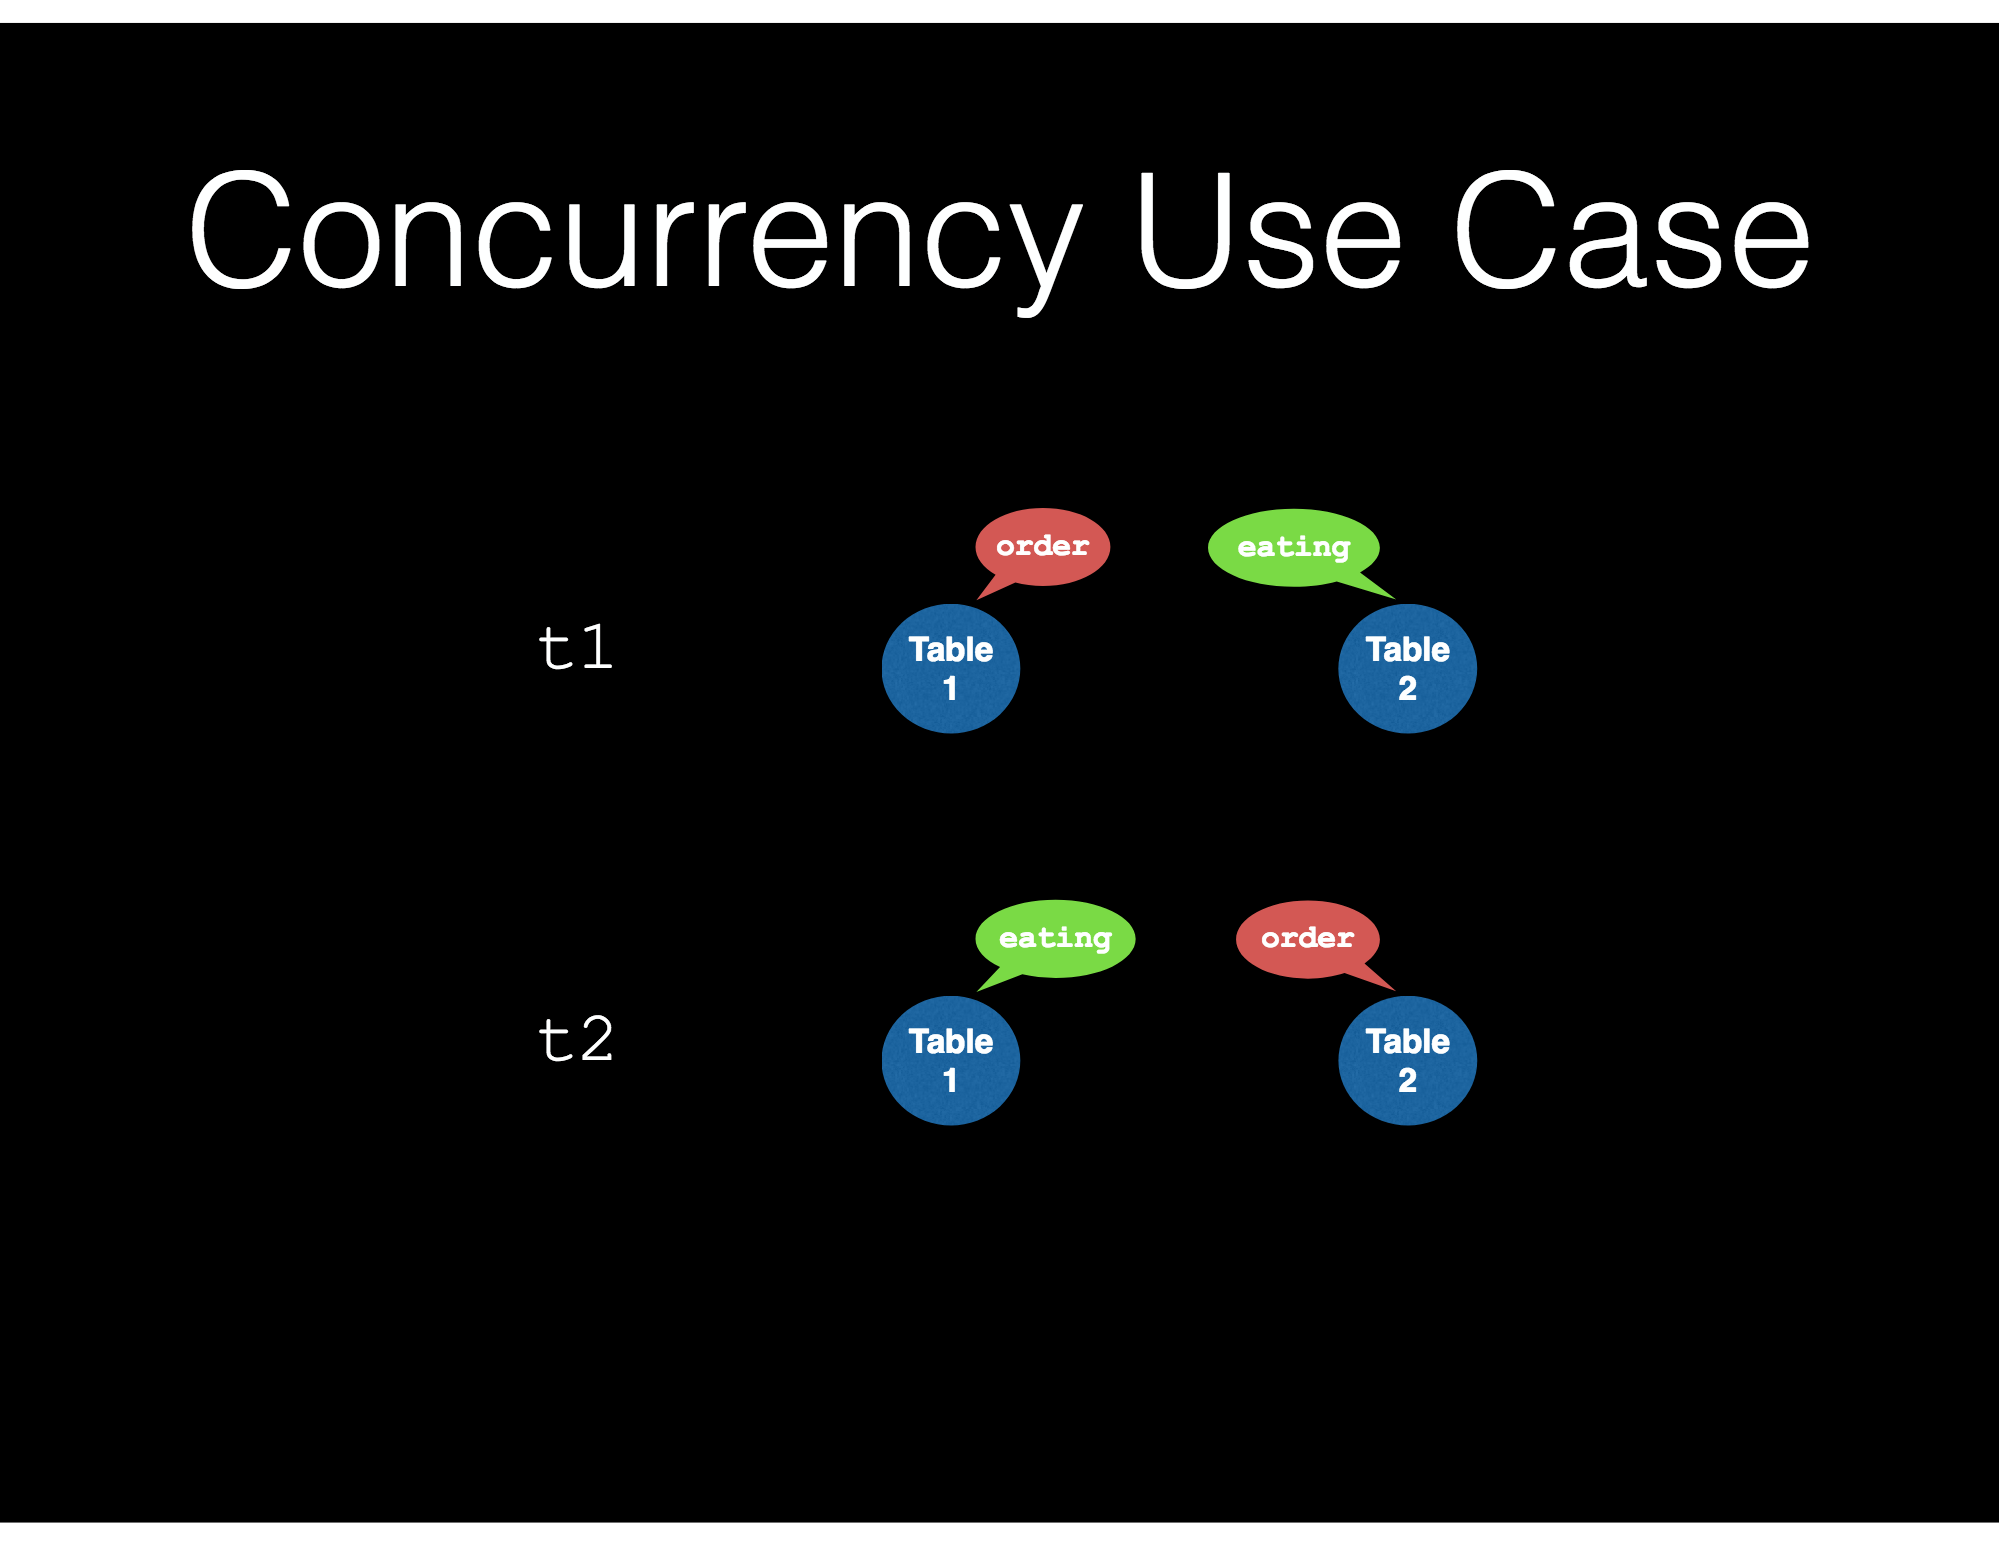

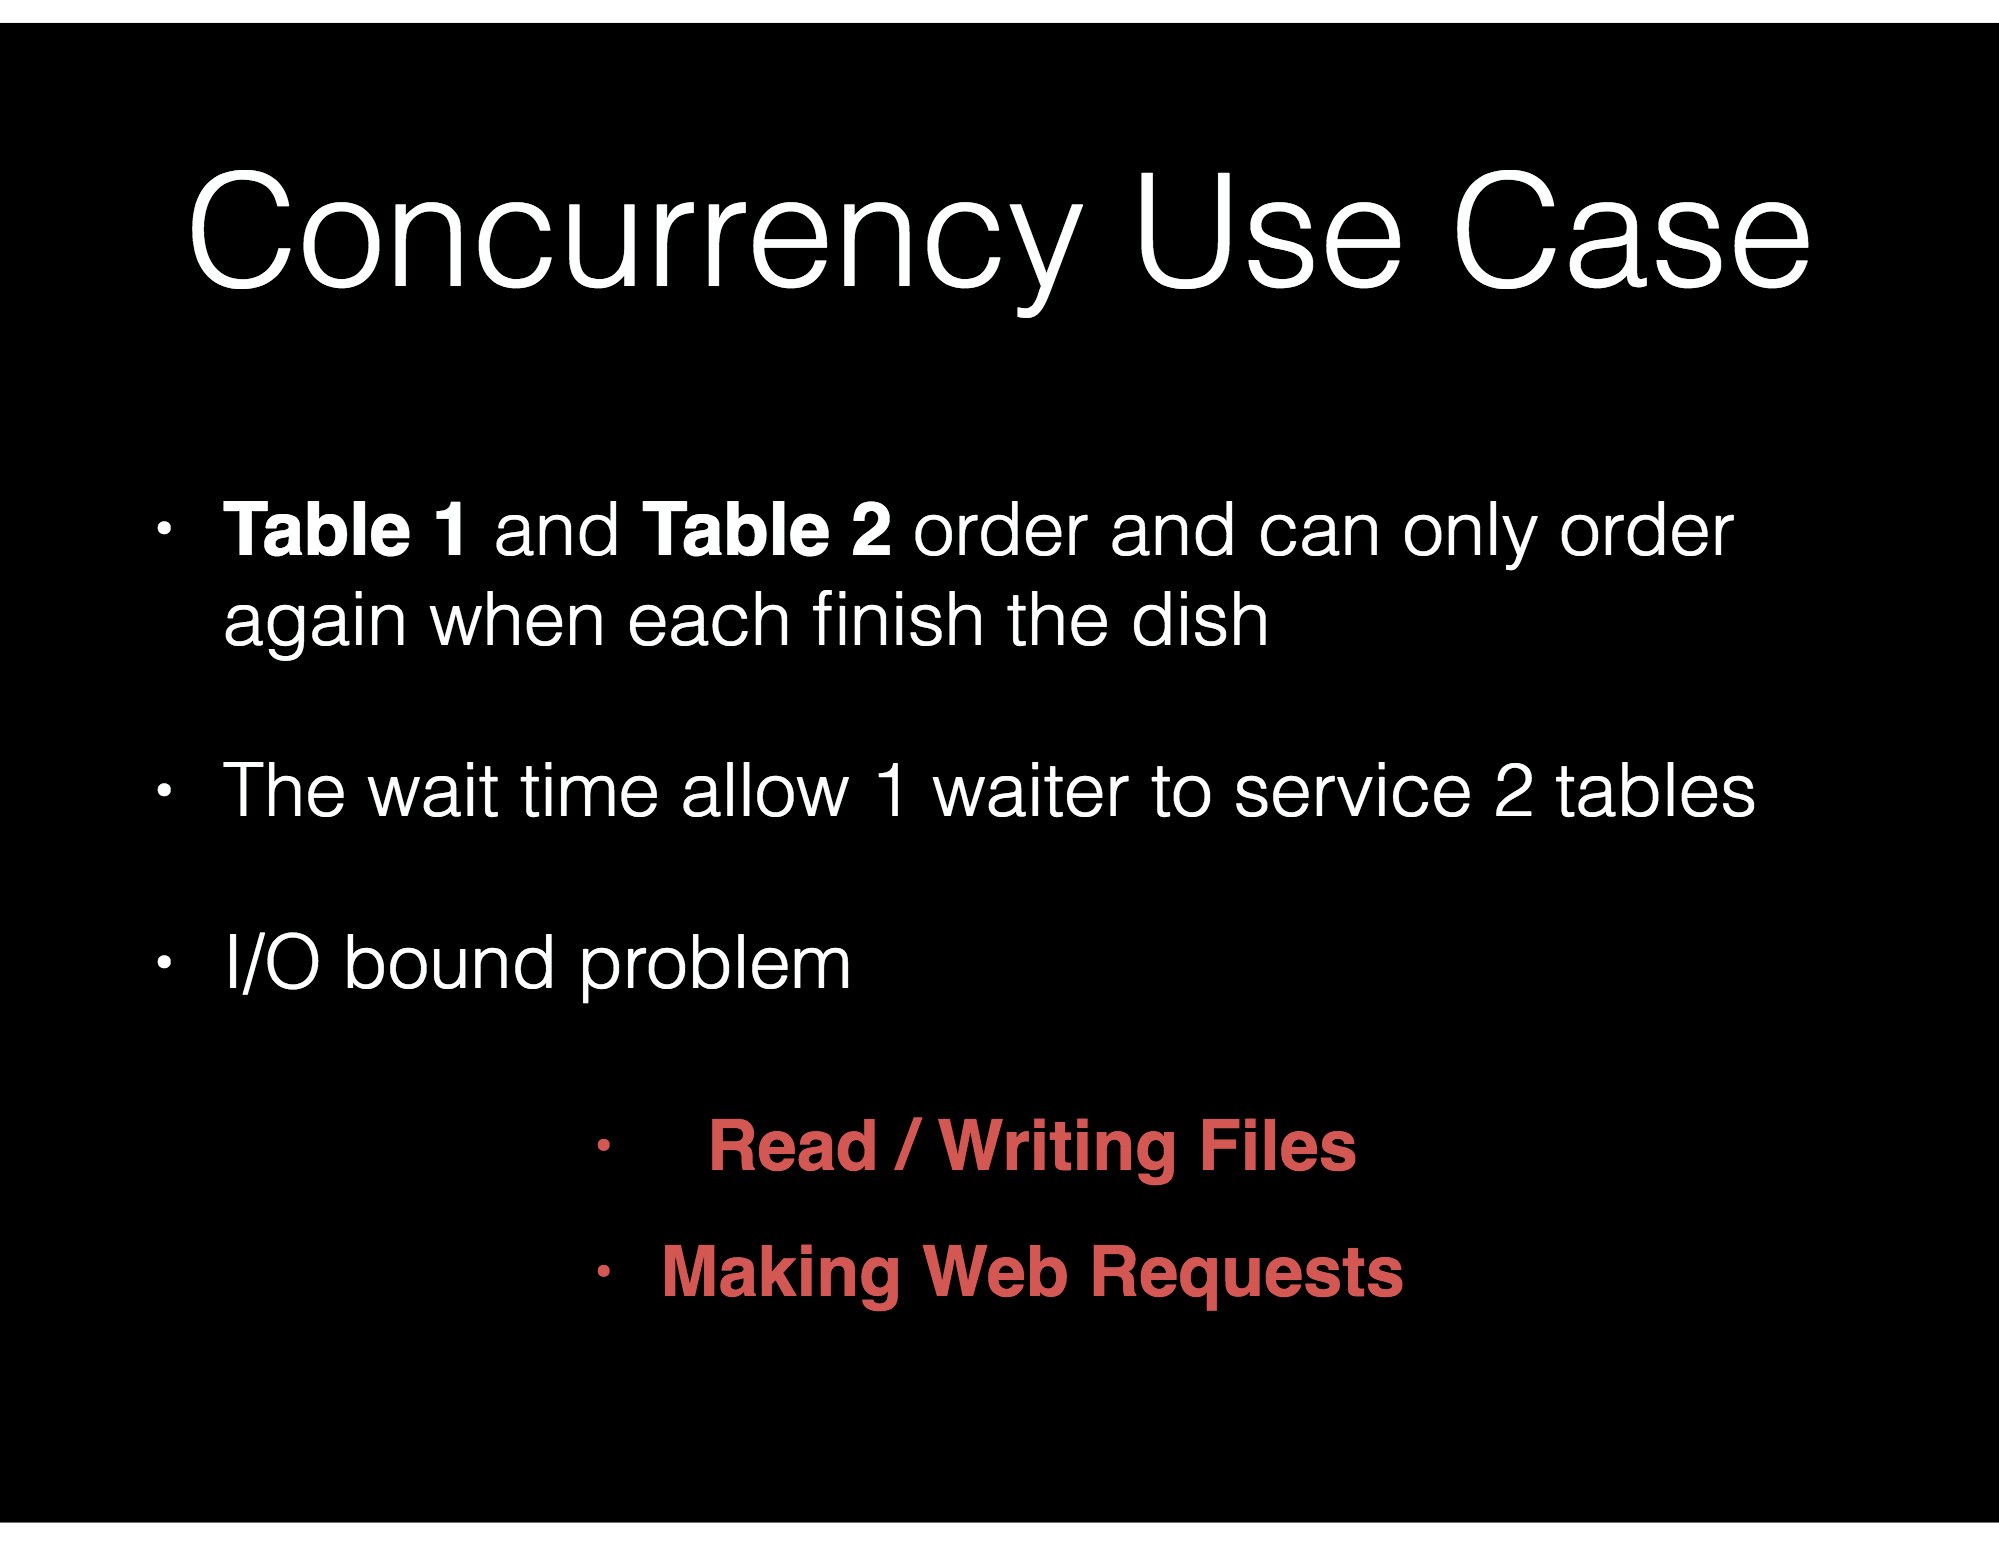

### Let's see how we can use multithreading with python:

___

In [12]:
import multiprocessing as mp
import requests
import sys
import threading
from timeit import Timer

### We first define several helpers to query a website we are interested into:

In [53]:
def request_item(item_id, return_dict):
    """Requests a spefcific item from algolia API.

    Parameters
    ----------
    item_id: an algolia item id.

    Returns
    -------
    a dict, except in event of requests error, then None.
    """
#     print('Starting thread %s\n' % threading.currentThread().getName())
    try:
        r = requests.get("https://hn.algolia.com/api/v1/items/%s" % item_id)
    except requests.RequestException:
        return None
#     print('Exiting thread %s\n' % threading.currentThread().getName())
    if r.status_code != 404:
        return_dict[item_id] = r.json()

### The following function request the items in a sequential fashion:

In [54]:
def request_sequential(index_min=1, index_max=20):
    """Requests a specific a bunch of items from algolia.

    Parameters
    ----------
    None

    Returns
    -------
    None.
    """
    sys.stdout.write("Requesting sequentially...\n")

    for item_id in list(range(index_min, index_max)):
        request_item(item_id, {})

    sys.stdout.write("done.\n")

### ... This one request the items in parallel:

In [55]:
def request_concurrent(index_min=1, index_max=20):
    """Requests a specific bunch of items from algolia IN PARALLEL

    Parameters
    ---------
    None

    Returns
    -------
    None
    """
    sys.stdout.write("Requesting in parallel...\n")

    jobs = []
    manager = mp.Manager()
    return_dict = manager.dict()
    for i in range(index_min, index_max):
        thread = threading.Thread(name=i, target=request_item, args=(i, return_dict))
        jobs.append(thread)
        thread.start()
    print("Waiting for threads to finish execution.")
    for j in jobs:
        j.join()
    return return_dict

### Let's see if this improves the time required to obtain the data:

In [ ]:
t = Timer(lambda: request_sequential())
print("Completed sequential in %s seconds." % t.timeit(1))
print("--------------------------------------")

Requesting sequentially...


In [ ]:
t = Timer(lambda: request_concurrent())
print("Completed using threads in %s seconds." % t.timeit(1))

In [ ]:
d_=request_concurrent()

In [ ]:
d_.values()


### Those are the steps required to multiprocess a request:

- Create a helper function with a dictionary placeholder to return the request

- Create an empty list, instantiate the queue manager and the final dictionary place holder that will collect the results of the threads:
```
jobs = []
manager = mp.Manager()
return_dict = manager.dict()
```
- Within a loop, create the threads calling the helper function, and storing them:
```
for i in range(index_min, index_max):
    thread = threading.Thread(name=i, target=request_item, args=(i, return_dict))
    jobs.append(thread)
    thread.start()
```
- Join the results of the requests
```
print("Waiting for threads to finish execution.")
for j in jobs:
    j.join()
```

### In summary:

Running several threads is similar to running several different programs concurrently, but with the following benefits:

- Multiple threads within a process **share the same data space with the main thread** and can therefore share information or communicate with each other more easily than if they were separate processes.

- Threads sometimes called **light-weight processes** and they do not require much memory overhead; they are cheaper than processes.

- A thread has **a beginning, an execution sequence, and a conclusion**. It has an instruction pointer that keeps track of where within its context it is currently running.

- It can **temporarily be put on hold** (also known as sleeping) while other threads are running - this is called yielding.

## Bonus: Multiprocesses in python

In [29]:
import math
import multiprocessing
import itertools
from timeit import Timer

In [30]:
def check_prime(n):
    """Checks if a number is prime.

    Parameters
    ----------
    n: an Int

    Returns
    -------
    Bool
    """
    if n % 2 == 0:
        return False
    for i in range(3, int(math.sqrt(n)) + 1, 2):
        if n % i == 0:
            return False
    return True

In [31]:
def primes_sequential(number_range):
    """Finds all primes in a sequence.

    Parameters
    ----------
    number_range: an iterable of ints

    Returns
    -------
    list of primes
    """
    primes = []
    for possible_prime in number_range:
        if check_prime(possible_prime):
            primes.append(possible_prime)
    return primes

In [32]:
def head_tail(primes):
    """Prints first and last 10 entries from a list (of primes here).
    This lets us see the output from our various jobs.

    Parameters
    ----------
    primes: a list

    Returns
    -------
    None. Side effect is print to stdout.
    """
    print(len(primes), primes[:10], primes[-10:])

In [33]:
def primes_parallel(number_range):
    """Computes primes in parallel using multiprocessing.

    Parameters
    ----------
    number_range: an iterable of ints to check for primeness.

    Returns
    -------
    list of primes
    """
    # multiprocessing.cpu_count() cores used.
    pool = multiprocessing.Pool()
    output = pool.map(check_prime, number_range)  # a list of booleans
    primes = [p for p in itertools.compress(number_range, output)]
    return primes

In [34]:
number_range = range(10, 2500000) # ~10sec 1 core 

# Make a list of functions to time.
# callables without args...
funcs = [primes_sequential, primes_parallel]
tests = [(test_func.__name__, test_func) for test_func in funcs]

for name, test in tests:
    # We have to do this because Timer takes a callable as an arg.
    t = Timer(lambda: head_tail(test(number_range)))
    print("Completed {name} in {time} seconds.".format(name=name,
                                                       time=t.timeit(1)))

183068 [11, 13, 17, 19, 23, 29, 31, 37, 41, 43] [2499923, 2499941, 2499943, 2499947, 2499949, 2499953, 2499967, 2499983, 2499989, 2499997]
Completed primes_sequential in 14.241352582001127 seconds.
183068 [11, 13, 17, 19, 23, 29, 31, 37, 41, 43] [2499923, 2499941, 2499943, 2499947, 2499949, 2499953, 2499967, 2499983, 2499989, 2499997]
Completed primes_parallel in 8.371371248038486 seconds.


Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/aymericflaisler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/aymericflaisler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/aymericflaisler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/aymericflaisler/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aymericflaisler/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aymericflaisler/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, 